In [1]:
import base64
from typing import List, TypedDict, Annotated, Optional,Dict, Any, Union
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage,AIMessage, ToolMessage
from langgraph.graph.message import add_messages
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display
import PIL
from langchain_google_genai import ChatGoogleGenerativeAI
import os
from dotenv import load_dotenv
import re
from langchain_core.tools import tool
import pandas as pd
import numpy as np
import json
import importlib
import sys
import matplotlib.pyplot as plt
import google.generativeai as genai
import time

load_dotenv()  # carga las variables del .env
api_key = os.getenv("GOOGLE_API_KEY")
api_key_multimodal = os.getenv("GOOGLE_API_KEY_MULTIMODAL")
os.environ["GOOGLE_API_KEY"] = api_key

class AgentState(TypedDict, total=False):
    archivo_input: str                 # Ruta o base64
    df: pd.DataFrame                   # DataFrame cargado
    estructura: dict                   # Tipos, nulls, etc.
    resumen: dict                      # Describe num y cat
    insights: str                      # Insights del LLM
    limpieza:str       
    historial_limpieza:list# Limpieza del LLM
    
    visualizaciones: list              # Sugerencias de plots
    graficos_generados : list  # Gráficos generados
    graficos: list      # Gráficos generados
    insights_graficos: list
    errores_graficos: list # Errores encontrados
    refinamiento_intentos: int
    
    estrategia_negocio: dict 
    decision_usuario: str
    
    modelo_autogl: Any                 # Predictor de AutoGluon entrenado
    leaderboard: dict                  # Resultados de todos los modelos
    metricas_modelo: dict              # Métricas detalladas del mejor modelo
    predicciones: pd.DataFrame         # Predicciones del modelo (opcional)
    modelo_interpretacion: dict        # Feature importance y análisis del modelo
    reporte_ml: str 
    
    reporte_final: str      
    errores: list
    messages: Annotated[list[AnyMessage],add_messages]
    



c:\Proyectos\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Tools

In [ ]:
def remove_duplicates(df: pd.DataFrame, subset: Optional[List[str]] = None) -> pd.DataFrame:
    """
    Elimina filas duplicadas del DataFrame
    
    Args:
        df: DataFrame a procesar
        subset: Lista de columnas a considerar para duplicados. Si es None, considera todas las columnas
    """
    initial_rows = len(df)
    df_cleaned = df.drop_duplicates(subset=subset)
    final_rows = len(df_cleaned)
    print(f"Filas eliminadas: {initial_rows - final_rows}")
    return df_cleaned

def handle_missing_values(df: pd.DataFrame, columns: Union[str, List[str]], method: str = "drop", fill_value: Any = None) -> pd.DataFrame:
    """
    Maneja valores faltantes en una o múltiples columnas
    
    Args:
        df: DataFrame a procesar
        columns: Nombre de la columna o lista de columnas
        method: 'drop', 'mean', 'median', 'mode', 'forward_fill', 'backward_fill', 'fill_value'
        fill_value: Valor específico para rellenar (solo si method='fill_value')
    """
    df_copy = df.copy()
    
    # Convertir a lista si es string
    if isinstance(columns, str):
        columns = [columns]
    
    # Verificar que todas las columnas existan
    missing_cols = [col for col in columns if col not in df_copy.columns]
    if missing_cols:
        raise ValueError(f"Columnas no encontradas: {missing_cols}")
    
    for column in columns:
        if method == "drop":
            df_copy = df_copy.dropna(subset=[column])
        elif method == "mean" and df_copy[column].dtype in ['int64', 'float64']:
            df_copy[column] = df_copy[column].fillna(df_copy[column].mean())
        elif method == "median" and df_copy[column].dtype in ['int64', 'float64']:
            df_copy[column] = df_copy[column].fillna(df_copy[column].median())
        elif method == "mode":
            mode_value = df_copy[column].mode().iloc[0] if not df_copy[column].mode().empty else None
            if mode_value is not None:
                df_copy[column] = df_copy[column].fillna(mode_value)
        elif method == "forward_fill":
            df_copy[column] = df_copy[column].fillna(method='ffill')
        elif method == "backward_fill":
            df_copy[column] = df_copy[column].fillna(method='bfill')
        elif method == "fill_value" and fill_value is not None:
            df_copy[column] = df_copy[column].fillna(fill_value)
    
    return df_copy

def remove_outliers(df: pd.DataFrame, columns: Union[str, List[str]], method: str = "iqr", factor: float = 1.5) -> pd.DataFrame:
    """
    Elimina outliers de una o múltiples columnas numéricas
    
    Args:
        df: DataFrame a procesar
        columns: Nombre de la columna o lista de columnas numéricas
        method: 'iqr' o 'zscore'
        factor: Factor para el método IQR (default 1.5) o threshold para z-score (default 1.5)
    """
    df_copy = df.copy()
    
    # Convertir a lista si es string
    if isinstance(columns, str):
        columns = [columns]
    
    # Verificar que todas las columnas existan y sean numéricas
    for column in columns:
        if column not in df_copy.columns:
            raise ValueError(f"Columna '{column}' no encontrada")
        if df_copy[column].dtype not in ['int64', 'float64']:
            raise ValueError(f"Columna '{column}' debe ser numérica")
    
    # Crear máscara para filtrar outliers
    mask = pd.Series([True] * len(df_copy), index=df_copy.index)
    
    for column in columns:
        if method == "iqr":
            Q1 = df_copy[column].quantile(0.25)
            Q3 = df_copy[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - factor * IQR
            upper_bound = Q3 + factor * IQR
            column_mask = (df_copy[column] >= lower_bound) & (df_copy[column] <= upper_bound)
            mask = mask & column_mask
        
        elif method == "zscore":
            from scipy import stats
            z_scores = np.abs(stats.zscore(df_copy[column].dropna()))
            # Crear máscara para esta columna considerando NaN
            column_mask = pd.Series([True] * len(df_copy), index=df_copy.index)
            valid_indices = df_copy[column].dropna().index
            column_mask.loc[valid_indices] = z_scores < factor
            mask = mask & column_mask
    
    df_copy = df_copy[mask]
    initial_rows = len(df)
    final_rows = len(df_copy)
    print(f"Filas eliminadas por outliers: {initial_rows - final_rows}")
    
    return df_copy

def convert_data_types(df: pd.DataFrame, columns_types: Dict[str, str]) -> pd.DataFrame:
    """
    Convierte el tipo de datos de múltiples columnas
    
    Args:
        df: DataFrame a procesar
        columns_types: Diccionario con {nombre_columna: tipo_objetivo}
                      tipos válidos: 'int', 'float', 'string', 'datetime', 'category'
    """
    df_copy = df.copy()
    
    # Verificar que todas las columnas existan
    missing_cols = [col for col in columns_types.keys() if col not in df_copy.columns]
    if missing_cols:
        raise ValueError(f"Columnas no encontradas: {missing_cols}")
    
    for column, target_type in columns_types.items():
        try:
            if target_type == "int":
                df_copy[column] = pd.to_numeric(df_copy[column], errors='coerce').astype('Int64')
            elif target_type == "float":
                df_copy[column] = pd.to_numeric(df_copy[column], errors='coerce')
            elif target_type == "string":
                df_copy[column] = df_copy[column].astype(str)
            elif target_type == "datetime":
                df_copy[column] = pd.to_datetime(df_copy[column], errors='coerce')
            elif target_type == "category":
                df_copy[column] = df_copy[column].astype('category')
            else:
                raise ValueError(f"Tipo '{target_type}' no válido para columna '{column}'")
        except Exception as e:
            raise ValueError(f"Error convirtiendo columna '{column}' a {target_type}: {str(e)}")
    
    return df_copy

def remove_columns(df: pd.DataFrame, columns: Union[str, List[str]]) -> pd.DataFrame:
    """
    Elimina una o múltiples columnas específicas del DataFrame
    
    Args:
        df: DataFrame a procesar
        columns: Nombre de la columna o lista de columnas a eliminar
    """
    df_copy = df.copy()
    
    # Convertir a lista si es string
    if isinstance(columns, str):
        columns = [columns]
    
    existing_columns = [col for col in columns if col in df_copy.columns]
    if existing_columns:
        df_copy = df_copy.drop(columns=existing_columns)
        print(f"Columnas eliminadas: {existing_columns}")
    else:
        print("No se encontraron columnas para eliminar")
    
    return df_copy

def clean_text_column(df: pd.DataFrame, columns: Union[str, List[str]], operations: List[str]) -> pd.DataFrame:
    """
    Limpia una o múltiples columnas de texto
    
    Args:
        df: DataFrame a procesar
        columns: Nombre de la columna o lista de columnas de texto
        operations: Lista de operaciones ['strip', 'lower', 'upper', 'remove_special_chars']
    """
    df_copy = df.copy()
    
    # Convertir a lista si es string
    if isinstance(columns, str):
        columns = [columns]
    
    # Verificar que todas las columnas existan
    missing_cols = [col for col in columns if col not in df_copy.columns]
    if missing_cols:
        raise ValueError(f"Columnas no encontradas: {missing_cols}")
    
    for column in columns:
        for operation in operations:
            if operation == "strip":
                df_copy[column] = df_copy[column].astype(str).str.strip()
            elif operation == "lower":
                df_copy[column] = df_copy[column].astype(str).str.lower()
            elif operation == "upper":
                df_copy[column] = df_copy[column].astype(str).str.upper()
            elif operation == "remove_special_chars":
                df_copy[column] = df_copy[column].astype(str).str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)
    
    print(f"Operaciones aplicadas a columnas {columns}: {operations}")
    return df_copy

def standardize_numeric_columns(df: pd.DataFrame, columns: Union[str, List[str]], method: str = "zscore") -> pd.DataFrame:
    """
    Estandariza columnas numéricas usando Z-score o Min-Max scaling
    
    Args:
        df: DataFrame a procesar
        columns: Nombre de la columna o lista de columnas numéricas
        method: 'zscore' para estandarización Z-score, 'minmax' para Min-Max scaling
    """
    df_copy = df.copy()
    
    # Convertir a lista si es string
    if isinstance(columns, str):
        columns = [columns]
    
    # Verificar que todas las columnas existan y sean numéricas
    for column in columns:
        if column not in df_copy.columns:
            raise ValueError(f"Columna '{column}' no encontrada")
        if df_copy[column].dtype not in ['int64', 'float64']:
            raise ValueError(f"Columna '{column}' debe ser numérica")
    
    for column in columns:
        if method == "zscore":
            mean_val = df_copy[column].mean()
            std_val = df_copy[column].std()
            df_copy[column] = (df_copy[column] - mean_val) / std_val
        elif method == "minmax":
            min_val = df_copy[column].min()
            max_val = df_copy[column].max()
            df_copy[column] = (df_copy[column] - min_val) / (max_val - min_val)
        else:
            raise ValueError(f"Método '{method}' no válido. Use 'zscore' o 'minmax'")
    
    print(f"Estandarización {method} aplicada a columnas: {columns}")
    return df_copy

def encode_categorical_columns(df: pd.DataFrame, columns: Union[str, List[str]], method: str = "onehot") -> pd.DataFrame:
    """
    Codifica columnas categóricas
    
    Args:
        df: DataFrame a procesar
        columns: Nombre de la columna o lista de columnas categóricas
        method: 'onehot' para One-Hot Encoding, 'label' para Label Encoding
    """
    df_copy = df.copy()
    
    # Convertir a lista si es string
    if isinstance(columns, str):
        columns = [columns]
    
    # Verificar que todas las columnas existan
    missing_cols = [col for col in columns if col not in df_copy.columns]
    if missing_cols:
        raise ValueError(f"Columnas no encontradas: {missing_cols}")
    
    for column in columns:
        if method == "onehot" and df_copy[column].nunique() < 50:
            # One-Hot Encoding
            dummies = pd.get_dummies(df_copy[column], prefix=column)
            df_copy = pd.concat([df_copy.drop(column, axis=1), dummies], axis=1)
        elif method == "label":
            # Label Encoding
            unique_values = df_copy[column].unique()
            label_map = {val: idx for idx, val in enumerate(unique_values)}
            df_copy[column] = df_copy[column].map(label_map)
        else:
            raise ValueError(f"Método '{method}' no válido. Use 'onehot' o 'label'")
    
    print(f"Codificación {method} aplicada a columnas: {columns}")
    return df_copy

def generar_nueva_tool(nombre: str, descripcion: str):
    """
    Genera una nueva tool con nombre y descripción, y la agrega a AVAILABLE_TOOLS.
    
    Args:
        nombre: Nombre de la tool
        descripcion: Descripción de la tool
    """
    llm = ChatGoogleGenerativeAI(
        model="gemini-2.0-flash",
        temperature=0.2,
        top_p=0.95,
        top_k=40,
        max_retries=3,
    )
    
    system_prompt = '''Eres un experto en limpieza de datos y generación de herramientas para procesamiento de DataFrames. 
Tu tarea es crear una nueva herramienta que realice una operación específica sobre un DataFrame. 
La herramienta debe ser capaz de recibir un DataFrame y devolver un DataFrame modificado según la operación definida.

Debes seguir las mejores prácticas de programación y asegurarte de que la herramienta sea eficiente y fácil de usar.
La herramienta debe ser capaz de manejar errores comunes y proporcionar mensajes claros en caso de fallos.
Tu respuesta debe ser un código Python válido que defina una función con el nombre y la descripción proporcionados.
La función debe incluir un docstring que explique su propósito, los parámetros de entrada y el valor de retorno.

Ejemplo de respuesta:
```python
def nombre_de_la_funcion(df: pd.DataFrame, parametro1: tipo, parametro2: tipo) -> pd.DataFrame:
    \"\"\"Descripción de la función.
    Args:   
        df: DataFrame a procesar
        parametro1: Descripción del parámetro 1
        parametro2: Descripción del parámetro 2
    Returns:
        DataFrame modificado
    \"\"\"
    # Lógica de la función
    return df_modificado
```'''

    prompt = f'''Crea una nueva función de Python llamada {nombre} que realice la siguiente operación sobre un DataFrame:
{descripcion}.

Asegúrate de que la función sea eficiente, maneje errores comunes y proporcione mensajes claros en caso de fallos.
Solo devolvé el código de la función.'''
    
    response = llm.invoke([
        SystemMessage(content=system_prompt),
        HumanMessage(content=prompt)
    ])
    
    if not response or not response.content:
        raise ValueError("No se pudo generar la herramienta. Respuesta vacía del LLM.")
    
    code = response.content.strip()

    # Extraer el bloque de código si viene dentro de markdown
    if code.startswith("```python"):
        code = code.split("```python")[1].split("```")[0].strip()
    elif code.startswith("```"):
        code = code.split("```")[1].split("```")[0].strip()

    # Ejecutar el código para registrar la función
    local_vars = {}
    try:
        exec(code, globals(), local_vars)
    except Exception as e:
        raise RuntimeError(f"Error ejecutando la función generada:\n{code}\n\nError: {e}")

    # Recuperar la función desde local_vars
    funcion_generada = local_vars.get(nombre)
    if funcion_generada is None or not callable(funcion_generada):
        raise ValueError(f"No se pudo encontrar la función '{nombre}' luego de ejecutarla.")

    # Agregarla a la lista de herramientas disponibles
    AVAILABLE_TOOLS.append(funcion_generada)

    print(f"✅ Función '{nombre}' generada y añadida a AVAILABLE_TOOLS.")
    return funcion_generada

# Lista actualizada de todas las tools disponibles
AVAILABLE_TOOLS = [
    remove_duplicates,
    handle_missing_values,
    remove_outliers,
    convert_data_types,
    remove_columns,
    clean_text_column,
    standardize_numeric_columns,
    encode_categorical_columns,
    generar_nueva_tool
]

# Generar descripción textual de las tools
textual_description_of_tools = ''
for tool in AVAILABLE_TOOLS:
    if hasattr(tool, '__doc__') and tool.__doc__:
        textual_description_of_tools += f"{tool.__name__}: {tool.__doc__}\n\n"
    else:
        textual_description_of_tools += f"{tool.__name__}: No hay descripción disponible.\n\n"

#### Nodos

##### EDA

In [3]:
def load_data(state: AgentState) -> AgentState:
    '''
    Carga un archivo CSV o Excel y devuelve un estado inicial del agente.
    Args:
        archivo_input (str): Ruta al archivo CSV o Excel.
    Returns:
        AgentState: Estado inicial del agente con el DataFrame cargado y estructura.
    '''
    print("\n" + "="*80)
    print("🔍 INICIANDO CARGA DE DATOS (nodo: load_data)")
    print("="*80)
    print(f"📁 Archivo a cargar: {state['archivo_input']}")
    
    try:
        print("⏳ Cargando archivo...")
        df = pd.read_csv(state['archivo_input']) if state['archivo_input'].endswith('.csv') else pd.read_excel(state['archivo_input'])
        state['df'] = df
        
        print(f"✅ Archivo cargado correctamente")
        print(f"📊 Dimensiones del dataset: {df.shape[0]:,} filas x {df.shape[1]} columnas")
        print(f"💾 Memoria utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
        print(f"🔤 Columnas disponibles: {list(df.columns)}")
        
        message = AIMessage(content=f"Archivo cargado correctamente con {df.shape[0]:,} filas y {df.shape[1]} columnas. Columnas: {list(df.columns)}")
        state['messages'].append(message)
        print("✅ Mensaje de AI registrado en el historial. Cantidad de mensajes en el historial:", len(state['messages']))
        return state
        
    except Exception as e:
        error_msg = f"Error al cargar el archivo: {str(e)}"
        print(f"❌ {error_msg}")
        state['errores'].append(error_msg)
        return state

In [4]:
def verificar_estructura(state: AgentState) -> AgentState:
    print("\n" + "="*80)
    print("🔬 VERIFICANDO ESTRUCTURA DEL DATASET (nodo: verificar_estructura)")
    print("="*80)
    
    try:
        df = state['df']
        cant_filas, cant_columnas = df.shape
        
        print(f"📐 Dimensiones: {cant_filas:,} filas x {cant_columnas} columnas")
        
        # Análisis de tipos de datos
        tipos_conteo = df.dtypes.value_counts()
        print(f"🏷️  Tipos de datos encontrados:")
        for tipo, cantidad in tipos_conteo.items():
            print(f"   • {tipo}: {cantidad} columnas")
        
        # Análisis de valores nulos
        nulls = df.isnull().sum()
        columnas_con_nulls = nulls[nulls > 0]
        
        if len(columnas_con_nulls) > 0:
            print(f"⚠️  Valores nulos detectados en {len(columnas_con_nulls)} columnas:")
            for col, cantidad_nulls in columnas_con_nulls.items():
                porcentaje = (cantidad_nulls / cant_filas) * 100
                print(f"   • {col}: {cantidad_nulls:,} ({porcentaje:.1f}%)")
        else:
            print("✅ No se encontraron valores nulos")
        
        # Crear estructura
        estructura = {
            'cant_filas': cant_filas,
            'cant_columnas': cant_columnas,
            'tipos': df.dtypes.to_dict(),
            'nulls': df.isnull().sum().to_dict()
        }
        state['estructura'] = estructura
        
        message = AIMessage(
            content=f"Estructura verificada: {cant_filas:,} filas, {cant_columnas} columnas. Tipos de datos y valores nulos analizados:\n" +
                    f"Tipos de datos de columnas: {df.dtypes.to_dict()}\n" +
                    f"Valores nulos por columna: {df.isnull().sum().to_dict()}",
            name="verificar_estructura"
        )
        state['messages'].append(message)
        print("✅ Mensaje de AI registrado en el historial. Cantidad de mensajes en el historial:", len(state['messages']))
        print(f"✅ Estructura verificada correctamente")
        return state
    
    except Exception as e:
        error_msg = f"Error al verificar la estructura: {str(e)}"
        print(f"❌ {error_msg}")
        state['errores'].append(error_msg)
        return state

In [ ]:
def resumen_estadistico(state: AgentState) -> AgentState:
    print("\n" + "="*80)
    print("📊 GENERANDO RESUMEN ESTADÍSTICO (nodo: resumen_estadistico)")
    print("="*80)
    
    df = state.get("df")
    if df is None:
        error_msg = "No se encontró DataFrame en el estado."
        print(f"❌ {error_msg}")
        state["errores"].append(error_msg)
        return state

    resumen = {}

    try:
        # Variables numéricas
        numericas = df.select_dtypes(include=["number"])
        print(f"🔢 Analizando {len(numericas.columns)} variables numéricas:")
        for col in numericas.columns:
            stats = numericas[col].describe()
            print(f"   • {col}: min={stats['min']:.2f}, max={stats['max']:.2f}, media={stats['mean']:.2f}")
        
        resumen["numericas"] = numericas.describe().to_dict()

        # Variables categóricas
        categoricas = df.select_dtypes(include=["object", "category", "bool"])
        print(f"🏷️  Analizando {len(categoricas.columns)} variables categóricas:")
        
        resumen_cat = {}
        for col in categoricas.columns:
            nunique = categoricas[col].nunique()
            top_value = categoricas[col].mode().iloc[0] if not categoricas[col].mode().empty else None
            freq = categoricas[col].value_counts().iloc[0] if not categoricas[col].value_counts().empty else None
            
            print(f"   • {col}: {nunique} valores únicos, más frecuente: '{top_value}' ({freq} veces)")
            
            resumen_cat[col] = {
                "nunique": nunique,
                "top": top_value,
                "freq": freq
            }
        resumen["categoricas"] = resumen_cat

        # Guardar en el estado
        state["resumen"] = resumen
        
        message = AIMessage(
            content=f"Resumen estadístico generado:\n" +
                    f"Variables numéricas:\n{resumen['numericas']}\n\n"
                    f"Variables categóricas:\n{resumen['categoricas']}",
            name="resumen_estadistico"
        )
        state['messages'].append(message)
        print("✅ Mensaje de AI registrado en el historial. Cantidad de mensajes en el historial:", len(state['messages']))
        print(f"✅ Resumen estadístico generado correctamente")

    except Exception as e:
        error_msg = f"Error al generar resumen estadístico: {str(e)}"
        print(f"❌ {error_msg}")
        state["errores"].append(error_msg)

    return state

In [6]:
def construir_input_llm(state: AgentState) -> dict:
    """
    Construye el input estructurado para el LLM con toda la información relevante
    """
    estructura = state.get("estructura", {})
    resumen = state.get("resumen", {})
    historial = state.get("historial_limpieza", [])
    
    # Información de calidad de datos
    nulls_info = estructura.get("nulls", {})
    total_nulls = sum(nulls_info.values())
    columnas_con_nulls = {k: v for k, v in nulls_info.items() if v > 0}
    
    # Análisis de tipos de datos
    tipos = estructura.get("tipos", {})
    tipos_problematicos = []
    for col, tipo in tipos.items():
        if str(tipo) == 'object' and col in resumen.get('categoricas', {}):
            if resumen['categoricas'][col].get('nunique', 0) > 50:
                tipos_problematicos.append(f"{col}: posible texto libre (demasiadas categorías únicas)")
    
    input_llm = {
        "estructura_dataset": {
            "filas": estructura.get("cant_filas"),
            "columnas": estructura.get("cant_columnas"),
            "tipos_por_columna": {k: str(v) for k, v in tipos.items()},
            "calidad_datos": {
                "total_valores_nulos": total_nulls,
                "columnas_con_nulos": columnas_con_nulls,
                "porcentaje_nulos_global": round((total_nulls / (estructura.get("cant_filas", 1) * estructura.get("cant_columnas", 1))) * 100, 2)
            }
        },
        "resumen_estadistico": {
            "variables_numericas": resumen.get("numericas", {}),
            "variables_categoricas": resumen.get("categoricas", {}),
            "posibles_problemas": tipos_problematicos
        },
        "historial_limpieza_aplicada": [
            {
                "paso": item.get("paso"),
                "accion": item.get("decision", {}).get("action"),
                "parametros": item.get("decision", {}).get("params"),
                "descripcion": item.get("decision", {}).get("message")
            }
            for item in historial
        ]
    }
    
    return input_llm

In [7]:
tools = AVAILABLE_TOOLS

def analisis_limpieza(state: AgentState) -> AgentState:
    """
    Analiza si el dataset necesita limpieza y decide qué acción tomar
    """
    print("\n" + "="*80)
    print("🧠 ANÁLISIS DE LIMPIEZA CON LLM (nodo: analisis_limpieza)")
    print("="*80)
    
    try:
        # Construir el input estructurado para el LLM
        input_llm = construir_input_llm(state)
        historial_limpieza = state.get('historial_limpieza', [])
        
        print(f"📋 Preparando información para el LLM...")
        print(f"🔍 Pasos de limpieza previos: {len(historial_limpieza)}")
        print(f"🛠️  Tools disponibles: {len(tools)}")
        
        # Crear el mensaje con la información del dataset
        dataset_info = f"""
        INFORMACIÓN DEL DATASET:
        {input_llm}
        
        HISTORIAL DE LIMPIEZA APLICADA:
        {[decision['decision'] for decision in historial_limpieza]}
        
        AVAILABLE TOOLS:
        {textual_description_of_tools}
        
        Analiza esta información y decide si el dataset necesita limpieza.
        Si necesita limpieza, selecciona UNA tool específica para aplicar. Solo podes elegir una tool de la lista proporcionada.
        Si consideras que el dataset ya está limpio y listo para análisis, indica 'no_limpieza_necesaria'.
        Si no encuentras la tool adecuada, indica 'generar_tool' con la descripción de lo que necesitas.
        
        Responde ÚNICAMENTE en formato JSON:
        {{
            "action": "nombre_de_tool_o_no_limpieza_necesaria_o_generar_tool",
            "params": {{"param1": "value1"}},
            "message": "Descripción de la acción"
        }}
        """
        
        print("🤖 Consultando al LLM para decisión de limpieza...")
        
        
        
        messages = [
            SystemMessage(content=SYSTEM_PROMPT),
            state['messages'][1],
            HumanMessage(content=dataset_info)
        ]
        
        # Invocar al LLM
        llm_response = llm.invoke(messages)
        response_content = llm_response.content.strip()
        
        print(f"💬 Respuesta del LLM recibida: {len(response_content)} caracteres")
        
        # Limpiar la respuesta si viene con marcadores de código
        if response_content.startswith('```json'):
            response_content = response_content.replace('```json', '').replace('```', '').strip()
            print("🧹 Limpiando formato markdown de la respuesta")
        
        try:
            decision = json.loads(response_content)
            state['limpieza'] = decision
            
            print(f"📝 Decisión del LLM: {decision['action']}")
            print(f"💬 Mensaje: {decision.get('message', 'Sin mensaje')}")
            if decision.get('params'):
                print(f"⚙️  Parámetros: {decision['params']}")
            
            # Agregar al historial de decisiones
            historial = state.get('historial_limpieza', [])
            historial.append({
                'paso': len(historial) + 1,
                'decision': decision,
                'timestamp': pd.Timestamp.now().isoformat()
            })
            state['historial_limpieza'] = historial
            if decision['action'] == 'no_limpieza_necesaria':
                print("✅ El LLM determinó que no es necesaria limpieza.")
                message1 = AIMessage(content="Informacion del dataset final:\n\n" + str(input_llm), name="informacion_dataset")
                state['messages'].append(message1)
                print("✅ Mensaje de AI registrado en el historial. Cantidad de mensajes en el historial:", len(state['messages']))
                message2 = AIMessage(
                    content=f"Pasos de limpieza:\n\n{[decision['decision'] for decision in historial_limpieza]}\n\nNo se requiere mas limpieza.",
                    name="analisis_limpieza"
                )
                
                state['messages'].append(message2)
                print("✅ Mensaje de AI registrado en el historial. Cantidad de mensajes en el historial:", len(state['messages']))
                return state
            else:
                message = AIMessage(
                    content=f"Decisión del LLM: {decision['action']}\n" +
                            f"Parámetros: {decision.get('params', {})}\n" +
                            f"Descripción: {decision.get('message', 'Sin descripción')}",
                    name="analisis_limpieza"
                )
                state['messages'].append(message)
                print("✅ Mensaje de AI registrado en el historial. Cantidad de mensajes en el historial:", len(state['messages']))
            print(f"✅ Decisión registrada en el historial (paso {len(historial)})")
            
        except json.JSONDecodeError as e:
            error_msg = f'Respuesta no válida del LLM: {response_content}'
            print(f"❌ Error parseando JSON: {str(e)}")
            print(f"🔍 Respuesta problemática: {response_content[:200]}...")
            
            state['limpieza'] = {
                'action': 'error',
                'message': error_msg
            }
            state['errores'].append(error_msg)
        
        return state
        
    except Exception as e:
        error_msg = f"Error en análisis de limpieza: {str(e)}"
        print(f"❌ {error_msg}")
        state['errores'].append(error_msg)
        state['limpieza'] = {
            'action': 'error',
            'message': f'Error interno: {str(e)}'
        }
        return state

In [8]:
def aplicar_tool_limpieza(state: AgentState) -> AgentState:
    """
    Aplica la tool de limpieza seleccionada por el LLM basándose en el último elemento del historial
    """
    print("\n" + "="*80)
    print("🔧 APLICANDO TOOL DE LIMPIEZA (nodo: aplicar_tool_limpieza)")
    print("="*80)
    
    try:
        historial = state.get('historial_limpieza', [])
        if not historial:
            error_msg = "No hay decisiones en el historial para aplicar"
            print(f"❌ {error_msg}")
            state['errores'].append(error_msg)
            return state
            
        # Obtener la última decisión del historial
        ultima_decision = historial[-1]['decision']
        action = ultima_decision.get('action')
        params = ultima_decision.get('params', {})
        
        print(f"🎯 Tool a aplicar: {action}")
        print(f"⚙️  Parámetros: {params}")
        print(f"📊 Shape antes: {state['df'].shape}")
        
        # Buscar la tool por nombre en las tools disponibles
        tool_found = None
        for tool in AVAILABLE_TOOLS:
            if hasattr(tool, '__name__') and tool.__name__ == action:
                tool_found = tool
                break
        
        if not tool_found:
            error_msg = f"Tool '{action}' no encontrada en AVAILABLE_TOOLS"
            print(f"❌ {error_msg}")
            print(f"🔍 Tools disponibles: {[tool.__name__ for tool in AVAILABLE_TOOLS]}")
            state['errores'].append(error_msg)
            # Marcar como fallida en el historial
            historial[-1]['aplicada'] = False
            historial[-1]['resultado'] = f'error: {error_msg}'
            return state
        
        print(f"✅ Tool encontrada: {tool_found.__name__}")
        
        # Preparar parámetros para la tool
        tool_params = params.copy()
        
        # Reemplazar 'df' string con el DataFrame real
        if 'df' in tool_params and tool_params['df'] == 'df':
            tool_params['df'] = state['df']
        elif 'df' not in tool_params:
            tool_params['df'] = state['df']
        
        print(f"🚀 Ejecutando {action}...")
        
        # Ejecutar la tool
        df_limpio = tool_found(**tool_params)
        
        # Actualizar el estado con el DataFrame limpio
        state['df'] = df_limpio
        
        print(f"📊 Shape después: {df_limpio.shape}")
        shape_antes = historial[-1]['decision'].get('shape_antes', 'N/A')
        if shape_antes != 'N/A':
            filas_eliminadas = shape_antes[0] - df_limpio.shape[0] if isinstance(shape_antes, tuple) else 0
            print(f"📉 Filas eliminadas: {filas_eliminadas}")
        
        print("🔄 Actualizando estructura y resumen...")
        
        # Actualizar estructura y resumen con los nuevos datos
        state = verificar_estructura(state)
        state = resumen_estadistico(state)
        
        # Registrar la acción como aplicada exitosamente
        historial[-1]['aplicada'] = True
        historial[-1]['resultado'] = 'exitoso'
        historial[-1]['shape_despues'] = df_limpio.shape
        
        print(f"✅ Tool '{action}' aplicada exitosamente")
        
        message = ToolMessage(
            content=f"Tool '{action}' aplicada exitosamente con parámetros: {tool_params}",
            name=action,
            tool_call_id=ultima_decision.get('tool_call_id', None)
        )
        
        state['messages'].append(message)
        print("✅ Mensaje de Tool registrado en el historial. Cantidad de mensajes en el historial:", len(state['messages']))
        
        return state
        
    except Exception as e:
        error_msg = f"Error aplicando tool: {str(e)}"
        print(f"❌ {error_msg}")
        state['errores'].append(error_msg)
        
        # Marcar como fallida en el historial
        historial = state.get('historial_limpieza', [])
        if historial:
            historial[-1]['aplicada'] = False
            historial[-1]['resultado'] = f'error: {error_msg}'
        
        return state


In [9]:
def route_analisis_limpieza(state: AgentState):
    """
    Ruta principal del agente que decide si analizar limpieza o aplicar tool
    """
    print("\n" + "="*80)
    print("🚦 DECISIÓN DE RUTA (nodo: route_analisis_limpieza)")
    print("="*80)
    
    df = state.get('df')
    if df is None or df.empty:
        error_msg = "No se ha cargado un DataFrame válido."
        print(f"❌ {error_msg}")
        state['errores'].append(error_msg)
        return state
    
    historial = state.get('historial_limpieza', [])
    
    ultima_accion = historial[-1]['decision']['action']
    print(f"🔍 Última acción del LLM: {ultima_accion}")
    
    if ultima_accion == 'no_limpieza_necesaria':
        print("✅ Decisión: El dataset está limpio, continuar a insights")
        return "No hace falta limpieza"
    else:
        print(f"🔧 Decisión: Aplicar tool de limpieza '{ultima_accion}'")
        return "Tool limpieza"

In [10]:
def sugerir_graficos_llm(state: AgentState) -> AgentState:
    print("\n" + "="*80)
    print("🧠 NODO: sugerir_graficos_llm")
    print("="*80)

    try:
        prompt = f"""
Teniendo en cuenta el dataset proporcionado y el objetivo de análisis sugerí visualizaciones útiles para entender las relaciones entre variables y la distribución del target.
Basado en esto, sugerí entre 3 y 6 gráficos útiles para entender las relaciones importantes entre variables y la distribución del target. Para cada gráfico, devolvé un JSON con el siguiente formato:

{{
  "id": "grafico_1",
  "tipo": "scatterplot" | "boxplot" | "histograma" | "heatmap" | "barplot",
  "columnas": ["col1", "col2"],
  "descripcion": "Relación entre col1 y col2"
}}

Solo devolvé una lista JSON con estos objetos. Nada más. No uses etiquetas de código como "```json" o "```python".
"""
        state['messages'].append(HumanMessage(content=prompt))
        print("✅ Mensaje de Humano registrado en el historial. Cantidad de mensajes en el historial:", len(state['messages']))
        print("🤖 Enviando a LLM...")
        response = llm.invoke(state['messages'])
        
        print("📝 Respuesta del LLM:")
        print(response.content)
        
        # 🆕 LIMPIEZA MEJORADA DE LA RESPUESTA
        response_content = response.content.strip()
        
        # Eliminar bloques de código markdown
        if response_content.startswith('```json'):
            response_content = response_content.replace('```json', '').replace('```', '').strip()
            print("🧹 Eliminando formato markdown de la respuesta")
        elif response_content.startswith('```'):
            response_content = response_content.replace('```', '').strip()
            print("🧹 Eliminando bloques de código de la respuesta")
        
        # Buscar el JSON válido usando regex
        json_match = re.search(r'\[.*\]', response_content, re.DOTALL)
        if json_match:
            json_content = json_match.group(0)
            print(f"🔍 JSON extraído: {json_content[:100]}...")
        else:
            json_content = response_content
            print("⚠️ No se encontró array JSON, usando respuesta completa")
        
        # Intentar parsear el JSON
        visualizaciones = json.loads(json_content)
        if not isinstance(visualizaciones, list):
            raise ValueError("La respuesta no es una lista JSON válida")
        
        state['visualizaciones'] = visualizaciones
        print(f"✅ Se sugirieron {len(visualizaciones)} visualizaciones")
        
            # Agregar mensaje de AI con las visualizaciones sugeridas
        state['messages'].append(AIMessage(
                content=f"Sugerencias de visualizaciones:\n{json.dumps(visualizaciones, indent=2, ensure_ascii=False, default=str)}",
                name="sugerir_graficos_llm"
        ))
        print("✅ Mensaje de AI registrado en el historial. Cantidad de mensajes en el historial:", len(state['messages']))
        print(f"📊 Dimensiones del dataset: {state['df'].shape}")

    except Exception as e:
        msg = f"❌ Error en generar_codigo_grafico_llm: {str(e)}"
        print(msg)
        state['errores'].append(msg)

    return state

In [ ]:
def generar_codigo_grafico_llm(state: AgentState) -> AgentState:
    print("\n" + "="*80)
    print("📊 NODO: generar_codigo_grafico_llm")
    print("="*80)

    try:
        print(state['df'].shape)
        df = state['df']
        visualizaciones = state.get('visualizaciones', [])
        generados = state.get('graficos_generados', [])
        contexto = state['messages'][1].content or "Análisis exploratorio para predecir una variable." 

        # Buscar la primera visualización pendiente
        pendiente = next((v for v in visualizaciones if v["id"] not in generados), None)
        if not pendiente:
            print("✅ Todos los gráficos ya fueron generados.")
            return state

        print(f"🛠️ Generando código para: {pendiente['id']} ({pendiente['tipo']})")

        # Preparar prompt
        graf_prompt = f"""
Generá código Python usando matplotlib o seaborn para construir un gráfico de tipo {pendiente["tipo"]}, 
que analice las columnas: {', '.join(pendiente["columnas"])}.

Descripción del gráfico: {pendiente["descripcion"]}

Contexto del análisis: {contexto}

No expliques nada, solo devolvé el código limpio en Python, listo para ejecutarse.
Usá como variable de entrada un DataFrame llamado `df`.
"""

        response = llm.invoke([
            SystemMessage(content="Sos un experto en visualización de datos y generación de gráficos con Python."),
            HumanMessage(content=graf_prompt)
        ])

        # Limpieza del código recibido
        codigo = response.content.strip()
        codigo = re.sub(r'if __name__ == [\'"]__main__[\'"]:(.*?)```', '', codigo, flags=re.DOTALL)
        codigo = codigo.strip('```python').strip('```').strip()
        codigo = codigo.replace("plt.show()", "")

        # Agregar ejecución automática si el código contiene una función
        match = re.search(r'def (\w+)\(df.*?\)', codigo)
        if match:
            nombre_funcion = match.group(1)

            # Buscar una línea comentada que invoque la función, por ejemplo:
            # plot_histogram(df, "col", "titulo")
            ejemplo_match = re.search(rf"#\s*{nombre_funcion}\((.*?)\)", codigo)

            if ejemplo_match:
                argumentos = ejemplo_match.group(1).strip()
                llamada_real = f"{nombre_funcion}({argumentos})"
                codigo += f"\n\n{llamada_real}"
                print(f"🔧 Se usó llamada comentada: {llamada_real}")
            else:
                # No hay llamada comentada, usar genérico
                llamada_generica = f"{nombre_funcion}(df)"
                codigo += f"\n\n{llamada_generica}"
                print(f"⚠️ No se encontró llamada comentada. Usando fallback: {llamada_generica}")
        else:
            print("❌ No se detectó ninguna función definida en el código.")


        # Guardar en el estado
        state['graficos'].append({"id": pendiente["id"], "codigo": codigo})
        state['graficos_generados'].append(pendiente["id"])
        
        print(f"✅ Código generado para {pendiente['id']}, guardado correctamente")

    except Exception as e:
        msg = f"❌ Error en generar_codigo_grafico_llm: {str(e)}"
        print(msg)
        state['errores'].append(msg)

    return state



In [12]:
def routing_graficos(state: AgentState) -> str:
    """
    Verifica si faltan gráficos por generar.
    Devuelve:
        - 'pendientes' si aún hay gráficos sin código
        - 'completo' si todos los códigos fueron generados
    """
    total_sugeridos = len(state['visualizaciones'])
    total_generados = len(state['graficos'])

    print("\n" + "="*80)
    print("🔀 NODO CONDICIONAL: routing_graficos")
    print(f"📊 Visualizaciones sugeridas: {total_sugeridos}")
    print(f"✅ Gráficos con código generado: {total_generados}")
    print("="*80)

    if total_generados < total_sugeridos:
        print("➡️ Faltan gráficos por generar: volver a generar_codigo_grafico_llm")
        return "pendientes"
    else:
        print("✅ Todos los gráficos fueron generados")
        return "completo"

In [13]:
def ejecutar_graficos(state: AgentState) -> AgentState:
    """
    Ejecuta el código Python generado por la LLM para crear gráficos
    y guarda las imágenes en disco, actualizando el estado.
    """
    print("\n" + "="*80)
    print("🖼️ NODO: ejecutar_graficos")
    print("="*80)

    try:
        df = state['df']
        output_dir = "graficos_generados"
        os.makedirs(output_dir, exist_ok=True)

        nuevos_graficos = {}

        for v in state['graficos']:
            # Saltar si ya es una ruta (ya fue ejecutado)
            graf_id = v['id']
            codigo = v['codigo']
            if isinstance(codigo, str) and os.path.exists(codigo):
                continue

            print(f"🧪 Ejecutando código para: {graf_id}")

            # Agregamos un cierre de figura automático para evitar overlaps
            exec_context = {"df": df, "plt": plt}
            try:
                exec(codigo, exec_context)

                # Guardar imagen
                ruta = os.path.join(output_dir, f"{graf_id}.png")
                plt.savefig(ruta, bbox_inches='tight')
                plt.close()

                nuevos_graficos[graf_id] = ruta
                print(f"✅ Guardado: {ruta}")

            except Exception as e:
                msg = f"❌ Error al ejecutar gráfico {graf_id}: {str(e)}"
                print(msg)
                error = {'grafico_id': graf_id, 'error': str(e)}
                state['errores_graficos'].append(error)
                state['errores'].append(msg)

        # Actualizar state.graficos reemplazando código por la ruta del archivo
        for graf in state['graficos']:
            graf_id = graf['id']
            if graf_id in nuevos_graficos:
                graf['ruta'] = nuevos_graficos[graf_id] # agregamos campo 'ruta'

        message = AIMessage(
            content=f"Gráficos ejecutados y guardados en {output_dir}. Nuevos gráficos generados: {len(nuevos_graficos)}",
            name="ejecutar_graficos"
        )
        state['messages'].append(message)
        print("✅ Mensaje de AI registrado en el historial. Cantidad de mensajes en el historial:", len(state['messages']))

    except Exception as e:
        msg = f"❌ Error general en ejecutar_graficos: {str(e)}"
        print(msg)
        state['errores'].append(msg)

    return state


In [14]:
def route_grafico_error(state: AgentState) -> str:
    print("\n" + "="*80)
    print("🚦 NODO CONDICIONAL: route_grafico_error")
    print("="*80)
    
    errores = state.get("errores_graficos", [])
    intentos_refinamiento = state.get("refinamiento_intentos", 0)
    max_intentos = 1  # Máximo 2 intentos de refinamiento
    
    print(f"❌ Errores de gráficos: {len(errores)}")
    print(f"🔄 Intentos de refinamiento: {intentos_refinamiento}/{max_intentos}")
    
    if len(errores) == 0:
        print("✅ No hay errores de gráficos")
        # Resetear contador cuando no hay errores
        state["refinamiento_intentos"] = 0
        return "continuar"
    elif intentos_refinamiento < max_intentos:
        print(f"🛠️ Intentando refinamiento (intento {intentos_refinamiento + 1}/{max_intentos})")
        return "refinar"
    else:
        print(f"⚠️ Máximo de intentos de refinamiento alcanzado ({max_intentos}). Continuando con gráficos disponibles...")
        # Limpiar errores para evitar loops infinitos
        state["errores_graficos"] = []
        state["refinamiento_intentos"] = 0
        return "continuar"

In [15]:
def refinar_codigo_grafico_llm(state: AgentState) -> AgentState:
    """Refina el código de los gráficos generados que tienen errores de ejecución."""

    print("\n" + "="*80)
    print("🛠️ NODO: refinamiento de código gráfico")
    print("="*80)

    # 🆕 Incrementar contador de intentos
    intentos = state.get("refinamiento_intentos", 0) + 1
    state["refinamiento_intentos"] = intentos
    print(f"🔄 Intento de refinamiento #{intentos}")

    try:
        errores = state.get("errores_graficos", [])
        if not errores:
            print("✅ No hay gráficos para refinar.")
            return state

        model = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0.1)
        prompt_sistema = """
Sos un asistente experto en Python. Vas a recibir una función ya generada que puede tener errores como:
- strings sin cerrar
- llamadas comentadas
- falta de ejecución de la función

Tu tarea es corregir SOLO esa función y su posible llamada al final. No agregues ejemplos, ni declares DataFrames ni imports innecesarios. No incluyas explicaciones. Devolvé SOLO el código corregido y ejecutable.
Si el código no tiene errores de sintaxis, devolvé el código tal cual, sin cambios.
"""

        errores_refinados = 0
        graficos_a_eliminar = []  # 🆕 Lista de gráficos que fallan refinamiento
        
        for error in errores[:]:  # 🆕 Usar copia de la lista para poder modificarla
            graf_id = error["grafico_id"]
            print(f"🔧 Refinando gráfico: {graf_id}")

            # Buscar el gráfico original
            grafico = next((g for g in state["graficos"] if g["id"] == graf_id), None)
            if not grafico:
                print(f"⚠️ No se encontró el gráfico {graf_id} en el estado.")
                continue

            original_code = grafico["codigo"]
            prompt_usuario = f"""
            Este es el código generado para crear un gráfico. Al ejecutarlo, se produjo el siguiente error:

            >>> {error['error']}

            Revisá el código y corregí el problema. Recordá:
            - No agregues DataFrames ni imports nuevos.
            - No reescribas el código completo si no es necesario.
            - Solo corregí lo justo y necesario para que funcione.

            Código original:
            {original_code}
            """
            
            try:
                # Invocar a la LLM
                print('Esperando')
                time.sleep(60)
                response = model.invoke([
                    SystemMessage(content=prompt_sistema),
                    HumanMessage(content=prompt_usuario)
                ])

                codigo_corregido = response.content.strip().strip("```python").strip("```")

                # Intentar descomentar llamada si es válida
                lineas = codigo_corregido.splitlines()
                for i, linea in enumerate(lineas):
                    if re.match(r"#\s*\w+\(.*\)", linea):  # detecta llamada comentada
                        try:
                            linea_eval = linea.lstrip("# ").strip()
                            compile(linea_eval, "<string>", "exec")
                            lineas[i] = linea_eval
                            print(f"🔧 Línea descomentada: {linea_eval}")
                            break
                        except SyntaxError:
                            continue

                grafico["codigo"] = "\n".join(lineas)
                errores_refinados += 1
                print(f"✅ Gráfico {graf_id} refinado exitosamente")
                
            except Exception as e:
                print(f"❌ Error refinando gráfico {graf_id}: {str(e)}")
                # 🆕 Marcar gráfico para eliminación completa
                graficos_a_eliminar.append(graf_id)
                print(f"🗑️ Gráfico {graf_id} será eliminado del flujo")

        # 🆕 ELIMINAR COMPLETAMENTE los gráficos que no se pudieron refinar
        if graficos_a_eliminar:
            print(f"\n🗑️ Eliminando {len(graficos_a_eliminar)} gráficos problemáticos:")
            
            # Eliminar de la lista de gráficos
            state["graficos"] = [g for g in state["graficos"] if g["id"] not in graficos_a_eliminar]
            
            # Eliminar de la lista de visualizaciones
            state["visualizaciones"] = [v for v in state.get("visualizaciones", []) if v["id"] not in graficos_a_eliminar]
            
            # Eliminar de gráficos generados
            state["graficos_generados"] = [g for g in state.get("graficos_generados", []) if g not in graficos_a_eliminar]
            
            # Eliminar insights de gráficos si existen
            state["insights_graficos"] = [i for i in state.get("insights_graficos", []) if i.get("id") not in graficos_a_eliminar]
            
            for graf_id in graficos_a_eliminar:
                print(f"   • {graf_id} eliminado completamente")

        # 🆕 Limpiar TODOS los errores (ya que los problemáticos fueron eliminados)
        state["errores_graficos"] = []
        
        print(f"\n✅ Refinamiento completado:")
        print(f"   • Gráficos refinados exitosamente: {errores_refinados}")
        print(f"   • Gráficos eliminados por errores: {len(graficos_a_eliminar)}")
        print(f"   • Gráficos restantes: {len(state['graficos'])}")

    except Exception as e:
        error_msg = f"❌ Error refinando código gráfico: {str(e)}"
        print(error_msg)
        state["errores"].append(error_msg)

    return state

In [16]:
def insights_graficos_llm(state : AgentState) -> AgentState:
    """
    Genera insights a partir de los gráficos generados, utilizando LLM para interpretar los resultados.
    """
    print("\n" + "="*80)
    print("🔍 NODO: insights_graficos_llm")
    print("="*80)

    try:
        if not state.get('graficos'):
            raise ValueError("No hay gráficos generados para analizar.")
        genai.configure(api_key=api_key_multimodal)

        model = genai.GenerativeModel("gemini-2.0-flash")
        
        model_system_prompt = '''Eres un experto en análisis de gráficos y visualización de datos.
        Tu tarea es analizar gráficos generados y extraer insights relevantes sobre las relaciones entre las variables representadas.
        Debes proporcionar un análisis claro y conciso, destacando patrones, tendencias y cualquier hallazgo importante.
        Evitá explicaciones largas o genéricas. Sé directo, claro y orientado a negocio.
        Si encuentras algún problema para analizar el gráfico, indícalo claramente.'''
        
        insights_graficos = []
        for graf in state['graficos']:
            graf_id = graf['id']
            ruta = graf.get('ruta', None)
            if not ruta or not os.path.exists(ruta):
                raise ValueError(f"Gráfico {graf_id} no tiene ruta válida o no fue generado correctamente.")
            
            prompt = f"""{state['messages'][1].content}.\n\nAnalizá el gráfico generado en {ruta} y extraé insights relevantes sobre la relación entre las variables representadas. Si tenes algun problema para analizar el gráfico, indicá que no se puede analizar."""
            img = PIL.Image.open(ruta)
            
            response = model.generate_content([model_system_prompt,prompt,img])
            insights = response.text.strip() 
            insights_graficos.append({
                "id": graf_id,
                "ruta": ruta,
                "insights": insights
            })
            print(f"✅ Insights generados para el gráfico {graf_id}")
            message = AIMessage(
                content=f"Insights para el gráfico {graf_id}:\n{insights}",
                name="insights_graficos_llm"
            )
            state['messages'].append(message)
            print("✅ Mensaje de AI registrado en el historial. Cantidad de mensajes en el historial:", len(state['messages']))
        state['insights_graficos'] = insights_graficos
        return state
    except Exception as e:
        msg = f"❌ Error en insights_graficos_llm: {str(e)}"
        print(msg)
        state['errores'].append(msg)
        return state
            

In [17]:
def insights_llm(state: AgentState) -> AgentState:
    """
    Genera insights del dataset utilizando el LLM
    """
    print("\n" + "="*80)
    print("💡 GENERANDO INSIGHTS CON LLM (nodo: insights_llm)")
    print("="*80)
    
    try:
        df = state.get('df')
        historial_limpieza = state.get('historial_limpieza', [])
        
        print(f"📊 Dataset final para insights: {df.shape}")
        print(f"🧹 Pasos de limpieza aplicados: {len(historial_limpieza)}")
        
        # Construir el input estructurado para el LLM
        input_llm = construir_input_llm(state)
        
        # Generar estadísticas adicionales para insights
        print("📈 Generando estadísticas adicionales...")
        
        # Análisis de correlaciones (solo para variables numéricas)
        correlaciones = {}
        numericas = df.select_dtypes(include=['number'])
        if len(numericas.columns) > 1:
            corr_matrix = numericas.corr()
            correlaciones_fuertes = []
            for i in range(len(corr_matrix.columns)):
                for j in range(i+1, len(corr_matrix.columns)):
                    corr_val = corr_matrix.iloc[i, j]
                    if abs(corr_val) > 0.7:
                        correlaciones_fuertes.append({
                            'var1': corr_matrix.columns[i],
                            'var2': corr_matrix.columns[j],
                            'correlacion': round(corr_val, 3)
                        })
            correlaciones['fuertes'] = correlaciones_fuertes
            print(f"🔗 Correlaciones fuertes encontradas: {len(correlaciones_fuertes)}")
        
        # Análisis de distribución de variables categóricas
        analisis_categoricas = {}
        categoricas = df.select_dtypes(include=['object', 'category'])
        for col in categoricas.columns:
            value_counts = df[col].value_counts()
            analisis_categoricas[col] = {
                'categorias_unicas': len(value_counts),
                'distribucion_top5': value_counts.head().to_dict(),
                'concentracion': round(value_counts.iloc[0] / len(df) * 100, 2) if len(value_counts) > 0 else 0
            }
        
        print(f"🏷️  Variables categóricas analizadas: {len(categoricas.columns)}")
        
        # Análisis de calidad final de datos
        calidad_final = {
            'completitud': round((1 - df.isnull().sum().sum() / (len(df) * len(df.columns))) * 100, 2),
            'filas_completas': len(df.dropna()),
            'duplicados_restantes': df.duplicated().sum(),
        }
        
        print(f"✅ Completitud final: {calidad_final['completitud']}%")
        print(f"📋 Filas completas: {calidad_final['filas_completas']:,}")
        
        print("🤖 Consultando al LLM para generar insights...")
        
        message_correlaciones = AIMessage(
            content=f"Análisis de correlaciones:\n{json.dumps(correlaciones, indent=2, ensure_ascii=False, default=str)}",
            name="analisis_correlaciones")
        
        message_calidad_final = AIMessage(
            content=f"Calidad final de datos:\n{json.dumps(calidad_final, indent=2, ensure_ascii=False, default=str)}",
            name="calidad_final_datos")
        
        state['messages'].append(message_correlaciones)
        print("✅ Mensaje de AI registrado en el historial. Cantidad de mensajes en el historial:", len(state['messages']))
        state['messages'].append(message_calidad_final)
        print("✅ Mensaje de AI registrado en el historial. Cantidad de mensajes en el historial:", len(state['messages']))
        # Crear prompt para insights
        insights_prompt = f"""
        Teniendo en cuenta el dataset proporcionado, la estructura, el resumen, el proceso de limpieza y las visualizaciones, genera insights valiosos y accionables.
        
        INSTRUCCIONES:
        1. Analiza este dataset de forma integral y profesional
        2. Genera insights valiosos y accionables basados en los datos
        3. Identifica patrones, anomalías y oportunidades
        4. Sugiere próximos pasos para análisis o modelado
        5. Considera el tipo de problema detectado y las variables disponibles
        6. Proporciona recomendaciones específicas para mejorar el análisis
        
        Estructura tu respuesta de manera clara y organizada con secciones bien definidas.
        """
        state['messages'].append(HumanMessage(content=insights_prompt))
        print("✅ Mensaje de Humano registrado en el historial. Cantidad de mensajes en el historial:", len(state['messages']))
        # Invocar al LLM para generar insights
        insights_response = llm.invoke(state['messages'])
        
        insights_generados = insights_response.content
        
        print(f"💬 Insights generados: {len(insights_generados)} caracteres")

        visualizaciones_texto = "\n".join([
            f"### 📊 Gráfico {item['id']}\n"
            f"- **Ruta**: {item['ruta']}\n"
            f"- **Insight**: {item['insights']}"
            for item in state.get("insights_graficos", [])
        ]) or "No se generaron visualizaciones."

        
        # Crear insights finales estructurados
        insights_finales = f"""
# 📊 ANÁLISIS COMPLETO DEL DATASET

## 📈 MÉTRICAS CLAVE
- **Filas procesadas**: {len(df):,}
- **Columnas analizadas**: {len(df.columns)}
- **Completitud de datos**: {calidad_final['completitud']}%
- **Variables numéricas**: {len(numericas.columns)}
- **Variables categóricas**: {len(categoricas.columns)}
- **Pasos de limpieza aplicados**: {len(historial_limpieza)}


## VISUALIZACIONES GENERADAS
{visualizaciones_texto}
---

{insights_generados}

---

## 🛠️ PROCESO DE LIMPIEZA APLICADO:
{chr(10).join([f"✅ **Paso {item['paso']}**: {item['decision'].get('action')} - {item['decision'].get('message')}" 
               for item in historial_limpieza if item.get('decision', {}).get('action')])}
        """
        
        state['insights'] = insights_finales
        
        print("✅ Insights generados y guardados en el estado")
        print("📝 Resumen de insights:")
        print(f"   • Pasos de limpieza documentados: {len(historial_limpieza)}")
        print(f"   • Correlaciones detectadas: {len(correlaciones.get('fuertes', []))}")
        print(f"   • Variables categóricas analizadas: {len(analisis_categoricas)}")
        
        state['messages'].append(AIMessage(
            content=insights_finales,
            name="insights_llm"
        ))
        print("✅ Mensaje de AI registrado en el historial. Cantidad de mensajes en el historial:", len(state['messages']))
    except Exception as e:
        error_msg = f"Error generando insights: {str(e)}"
        print(f"❌ {error_msg}")
        state['errores'].append(error_msg)
        state['insights'] = f"❌ Error al generar insights: {error_msg}"
    
    return state

In [ ]:
from datetime import datetime

def reporte_final_llm_mejorado(state: AgentState) -> AgentState:
    print("\n" + "="*80)
    print("📄 NODO: reporte_final_llm_mejorado")
    print("="*80)

    try:
        output_dir = "reportes"
        os.makedirs(output_dir, exist_ok=True)

        df = state['df']
        insights_raw = state['insights']
        graficos = state['graficos']
        insights_graficos = state.get('insights_graficos', [])
        limpieza = state.get('historial_limpieza', [])
        
        # 🆕 OBTENER RESULTADOS DE MACHINE LEARNING
        modelo_autogl = state.get('modelo_autogl')
        metricas_modelo = state.get('metricas_modelo', {})
        leaderboard = state.get('leaderboard', {})
        estrategia_negocio = state.get('estrategia_negocio', {})

        nombre_archivo = f"reporte_final_{datetime.now().strftime('%Y%m%d_%H%M%S')}.html"
        ruta_reporte = os.path.join(output_dir, nombre_archivo)

        print(f"📝 Generando reporte mejorado en: {ruta_reporte}")
        print(f"🖼️ Gráficos disponibles: {len(graficos)}")
        print(f"💡 Insights de gráficos disponibles: {len(insights_graficos)}")
        print(f"🤖 Modelo ML disponible: {'✅' if modelo_autogl else '❌'}")

        # Función para convertir imágenes a base64
        def imagen_a_base64(ruta_imagen):
            try:
                if not os.path.exists(ruta_imagen):
                    return None
                with open(ruta_imagen, "rb") as img_file:
                    img_data = img_file.read()
                    base64_string = base64.b64encode(img_data).decode('utf-8')
                    return base64_string
            except Exception as e:
                print(f"❌ Error convirtiendo imagen {ruta_imagen}: {e}")
                return None

        # Asegurar rutas de gráficos
        for grafico in graficos:
            if 'ruta' not in grafico:
                ruta_esperada = os.path.join("graficos_generados", f"{grafico['id']}.png")
                if os.path.exists(ruta_esperada):
                    grafico['ruta'] = ruta_esperada

        # Función para obtener insight de un gráfico específico
        def obtener_insight_grafico(graf_id):
            """Busca el insight correspondiente a un gráfico específico"""
            for insight in insights_graficos:
                if insight.get('id') == graf_id:
                    return insight.get('insights', 'No se generaron insights para este gráfico.')
            return 'No se generaron insights para este gráfico.'

        # Función mejorada para procesar insights
        def procesar_insights(text):
            if not text:
                return "<p class='no-content'>No hay insights disponibles.</p>"
            
            # Limpiar secciones innecesarias
            text = re.sub(r'# 📊 ANÁLISIS COMPLETO DEL DATASET.*?---', '', text, flags=re.DOTALL)
            text = re.sub(r'## 📈 MÉTRICAS CLAVE.*?---', '', text, flags=re.DOTALL)
            text = re.sub(r'## VISUALIZACIONES GENERADAS.*?---', '', text, flags=re.DOTALL)
            text = re.sub(r'---\s*## 🛠️ PROCESO DE LIMPIEZA APLICADO:.*$', '', text, flags=re.DOTALL)
            
            # Dividir en secciones principales
            secciones = text.split('##')
            html_sections = ""
            
            for i, seccion in enumerate(secciones):
                if seccion.strip():
                    # Procesar título de sección
                    lines = seccion.strip().split('\n')
                    if lines:
                        titulo = lines[0].strip()
                        contenido = '\n'.join(lines[1:]) if len(lines) > 1 else ""
                        
                        # Convertir contenido
                        contenido_html = contenido
                        contenido_html = re.sub(r'\*\*(.*?)\*\*', r'<strong class="highlight">\1</strong>', contenido_html)
                        contenido_html = re.sub(r'^\* (.*)', r'<li class="insight-item">• \1</li>', contenido_html, flags=re.MULTILINE)
                        contenido_html = re.sub(r'^- (.*)', r'<li class="insight-item">• \1</li>', contenido_html, flags=re.MULTILINE)
                        
                        # Agrupar listas
                        lines = contenido_html.split('\n')
                        result = []
                        in_list = False
                        
                        for line in lines:
                            if '<li class="insight-item">' in line:
                                if not in_list:
                                    result.append('<ul class="insight-list">')
                                    in_list = True
                                result.append(line)
                            else:
                                if in_list:
                                    result.append('</ul>')
                                    in_list = False
                                if line.strip():
                                    result.append(f'<p class="insight-text">{line.strip()}</p>')
                        
                        if in_list:
                            result.append('</ul>')
                        
                        contenido_final = '\n'.join(result)
                        
                        html_sections += f"""
                        <div class="insight-section">
                            <h3 class="insight-section-title">{titulo}</h3>
                            <div class="insight-content">
                                {contenido_final}
                            </div>
                        </div>
                        """
            
            return html_sections

        insights_html = procesar_insights(insights_raw)

        # 🆕 FUNCIÓN PARA GENERAR SECCIÓN DE MACHINE LEARNING
        def generar_seccion_ml():
            if not modelo_autogl or not metricas_modelo:
                return '''
                <div class="no-content-card">
                    <div class="no-content-icon">🤖</div>
                    <h3>Sin Modelo de Machine Learning</h3>
                    <p>No se entrenó ningún modelo de Machine Learning en este análisis.</p>
                </div>
                '''
            
            # Extraer métricas principales
            mejor_modelo = metricas_modelo.get('mejor_modelo', 'N/A')
            score_validacion = metricas_modelo.get('score_validacion', 0)
            cantidad_modelos = metricas_modelo.get('cantidad_modelos', 0)
            tipo_problema = metricas_modelo.get('tipo_problema', 'N/A')
            variable_objetivo = metricas_modelo.get('variable_objetivo', 'N/A')
            feature_importance = metricas_modelo.get('feature_importance', {})
            
            # Determinar tipo de métrica según el problema
            metrica_nombre = "Accuracy" if tipo_problema in ["binary", "multiclass"] else "R² Score" if tipo_problema == "regression" else "Score"
            
            # Generar tabla de feature importance
            feature_importance_html = ""
            if feature_importance:
                top_features = sorted(feature_importance.items(), key=lambda x: abs(x[1]), reverse=True)[:10]
                feature_importance_html = """
                <div class="feature-importance">
                    <h4 class="section-subtitle">🔝 Variables Más Importantes</h4>
                    <div class="importance-table">
                """
                
                for i, (feature, importance) in enumerate(top_features, 1):
                    importance_percent = abs(importance) * 100 if abs(importance) <= 1 else abs(importance)
                    bar_width = min(importance_percent, 100)
                    
                    feature_importance_html += f"""
                    <div class="importance-row">
                        <div class="importance-rank">{i}</div>
                        <div class="importance-name">{feature}</div>
                        <div class="importance-bar">
                            <div class="importance-fill" style="width: {bar_width}%"></div>
                        </div>
                        <div class="importance-value">{importance:.3f}</div>
                    </div>
                    """
                
                feature_importance_html += """
                    </div>
                </div>
                """
            
            # Información del problema de negocio
            problema_negocio_html = ""
            if estrategia_negocio:
                problema_negocio_html = f"""
                <div class="business-problem">
                    <h4 class="section-subtitle">🎯 Problema de Negocio</h4>
                    <div class="problem-card">
                        <p><strong>Descripción:</strong> {estrategia_negocio.get('problema_negocio', 'N/A')}</p>
                        <p><strong>Justificación ML:</strong> {estrategia_negocio.get('justificacion_ml', 'N/A')}</p>
                        <p><strong>Comentarios:</strong> {estrategia_negocio.get('comentarios_adicionales', 'N/A')}</p>
                    </div>
                </div>
                """
            
            return f"""
            <div class="ml-results">
                <div class="ml-summary">
                    <div class="ml-metrics-grid">
                        <div class="ml-metric-card primary">
                            <div class="metric-icon">🏆</div>
                            <div class="metric-content">
                                <div class="metric-value">{score_validacion:.3f}</div>
                                <div class="metric-label">{metrica_nombre}</div>
                            </div>
                        </div>
                        <div class="ml-metric-card">
                            <div class="metric-icon">🤖</div>
                            <div class="metric-content">
                                <div class="metric-value">{cantidad_modelos}</div>
                                <div class="metric-label">Modelos Evaluados</div>
                            </div>
                        </div>
                        <div class="ml-metric-card">
                            <div class="metric-icon">🎯</div>
                            <div class="metric-content">
                                <div class="metric-value">{tipo_problema.title()}</div>
                                <div class="metric-label">Tipo de Problema</div>
                            </div>
                        </div>
                        <div class="ml-metric-card">
                            <div class="metric-icon">📊</div>
                            <div class="metric-content">
                                <div class="metric-value">{variable_objetivo}</div>
                                <div class="metric-label">Variable Objetivo</div>
                            </div>
                        </div>
                    </div>
                </div>
                
                <div class="ml-details">
                    <div class="model-info">
                        <h4 class="section-subtitle">🥇 Mejor Modelo</h4>
                        <div class="model-card">
                            <h5>{mejor_modelo}</h5>
                            <p>Este modelo fue seleccionado automáticamente por AutoGluon tras evaluar {cantidad_modelos} algoritmos diferentes.</p>
                        </div>
                    </div>
                    
                    {problema_negocio_html}
                    {feature_importance_html}
                </div>
            </div>
            """

        ml_html = generar_seccion_ml()

        # Estadísticas del dataset (incluyendo contadores ML)
        completitud = round((1 - df.isnull().sum().sum() / (len(df) * len(df.columns))) * 100, 1)
        tiene_modelo = 1 if modelo_autogl else 0
        
        stats_html = f"""
        <div class="stats-grid">
            <div class="stat-card">
                <div class="stat-icon">📊</div>
                <div class="stat-content">
                    <div class="stat-number">{len(df):,}</div>
                    <div class="stat-label">Filas de Datos</div>
                </div>
            </div>
            <div class="stat-card">
                <div class="stat-icon">📋</div>
                <div class="stat-content">
                    <div class="stat-number">{len(df.columns)}</div>
                    <div class="stat-label">Variables</div>
                </div>
            </div>
            <div class="stat-card">
                <div class="stat-icon">✅</div>
                <div class="stat-content">
                    <div class="stat-number">{completitud}%</div>
                    <div class="stat-label">Completitud</div>
                </div>
            </div>
            <div class="stat-card">
                <div class="stat-icon">🤖</div>
                <div class="stat-content">
                    <div class="stat-number">{tiene_modelo}</div>
                    <div class="stat-label">Modelo ML</div>
                </div>
            </div>
        </div>
        """

        # Mapeo de nombres de funciones a nombres más descriptivos
        nombres_funciones = {
            'remove_columns': 'Eliminar Columnas',
            'encode_categorical_columns': 'Codificar Variables Categóricas',
            'standardize_numeric_columns': 'Estandarizar Variables Numéricas',
            'remove_duplicates': 'Eliminar Duplicados',
            'handle_missing_values': 'Manejar Valores Faltantes',
            'remove_outliers': 'Eliminar Valores Atípicos',
            'convert_data_types': 'Convertir Tipos de Datos',
            'clean_text_column': 'Limpiar Columnas de Texto'
        }

        # Proceso de limpieza mejorado
        limpieza_html = ""
        pasos_validos = [item for item in limpieza if item.get('decision', {}).get('action') != 'no_limpieza_necesaria']
        
        if pasos_validos:
            for i, item in enumerate(pasos_validos, 1):
                if item.get('decision'):
                    accion = item['decision'].get('action', 'N/A')
                    mensaje = item['decision'].get('message', 'Sin descripción')
                    resultado = item.get('resultado', 'pendiente')
                    
                    # Nombre más descriptivo
                    nombre_descriptivo = nombres_funciones.get(accion, accion.replace('_', ' ').title())
                    
                    status_icon = "✅" if resultado == "exitoso" else "⚠️" if resultado == "pendiente" else "❌"
                    status_class = "success" if resultado == "exitoso" else "warning" if resultado == "pendiente" else "error"
                    
                    limpieza_html += f"""
                    <div class="process-step {status_class}">
                        <div class="step-header">
                            <div class="step-number">
                                <span class="number">{i}</span>
                                <div class="step-line"></div>
                            </div>
                            <div class="step-info">
                                <h4 class="step-title">{nombre_descriptivo}</h4>
                                <div class="step-status">
                                    <span class="status-icon">{status_icon}</span>
                                    <span class="status-text">{'Completado' if resultado == 'exitoso' else 'Error' if 'error' in resultado else 'Pendiente'}</span>
                                </div>
                            </div>
                        </div>
                        <div class="step-description">
                            <p>{mensaje}</p>
                        </div>
                    </div>
                    """
        else:
            limpieza_html = '''
            <div class="no-process">
                <div class="no-process-icon">🎯</div>
                <h3>Dataset Optimizado</h3>
                <p>Los datos ya se encontraban en excelente estado y no requirieron pasos de limpieza adicionales.</p>
            </div>
            '''

        # Generar sección de gráficos CON INSIGHTS
        graficos_html = ""
        if graficos and len(graficos) > 0:
            graficos_procesados = 0
            for i, grafico in enumerate(graficos):
                graf_id = grafico['id']
                ruta_imagen = grafico.get('ruta')
                
                if ruta_imagen and os.path.exists(ruta_imagen):
                    file_size = os.path.getsize(ruta_imagen)
                    if file_size > 0:
                        img_base64 = imagen_a_base64(ruta_imagen)
                        if img_base64:
                            # Obtener descripción
                            descripcion = "Visualización de datos"
                            visualizaciones = state.get('visualizaciones', [])
                            for viz in visualizaciones:
                                if viz.get('id') == graf_id:
                                    descripcion = viz.get('descripcion', descripcion)
                                    break
                            
                            # Obtener insight específico del gráfico
                            insight_grafico = obtener_insight_grafico(graf_id)
                            
                            # Procesar el insight para formato HTML
                            insight_procesado = insight_grafico.replace('\n', '<br>')
                            insight_procesado = re.sub(r'\*\*(.*?)\*\*', r'<strong>\1</strong>', insight_procesado)
                            insight_procesado = re.sub(r'^\* (.*)', r'<li>\1</li>', insight_procesado, flags=re.MULTILINE)
                            
                            # Si hay elementos de lista, envolverlos en <ul>
                            if '<li>' in insight_procesado:
                                lines = insight_procesado.split('<br>')
                                processed_lines = []
                                in_list = False
                                
                                for line in lines:
                                    if '<li>' in line:
                                        if not in_list:
                                            processed_lines.append('<ul>')
                                            in_list = True
                                        processed_lines.append(line)
                                    else:
                                        if in_list:
                                            processed_lines.append('</ul>')
                                            in_list = False
                                        if line.strip():
                                            processed_lines.append(line)
                                
                                if in_list:
                                    processed_lines.append('</ul>')
                                
                                insight_procesado = '<br>'.join(processed_lines)
                            
                            graficos_html += f"""
                            <div class="chart-container">
                                <div class="chart-header">
                                    <div class="chart-info">
                                        <h3 class="chart-title">{graf_id.replace('_', ' ').title()}</h3>
                                        <p class="chart-description">{descripcion}</p>
                                    </div>
                                    <div class="chart-badge">
                                        <span class="badge-number">{i+1}</span>
                                    </div>
                                </div>
                                <div class="chart-content">
                                    <img src="data:image/png;base64,{img_base64}" alt="{graf_id}" class="chart-image">
                                </div>
                                <div class="chart-insights">
                                    <h4 class="insights-title">💡 Análisis del Gráfico</h4>
                                    <div class="insights-content">
                                        <p>{insight_procesado}</p>
                                    </div>
                                </div>
                            </div>
                            """
                            graficos_procesados += 1
            
            if graficos_procesados == 0:
                graficos_html = '''
                <div class="no-content-card">
                    <div class="no-content-icon">📊</div>
                    <h3>Gráficos en Proceso</h3>
                    <p>Los gráficos están siendo generados. Verifica la carpeta "graficos_generados".</p>
                </div>
                '''
        else:
            graficos_html = '''
            <div class="no-content-card">
                <div class="no-content-icon">📈</div>
                <h3>Sin Visualizaciones</h3>
                <p>No se generaron visualizaciones para este análisis.</p>
            </div>
            '''

        # HTML completo con estilos mejorados (incluyendo estilos para ML)
        html = f"""
<!DOCTYPE html>
<html lang="es">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>📊 Análisis de Datos - DataViz AI</title>
    <link href="https://fonts.googleapis.com/css2?family=Inter:wght@300;400;500;600;700;800&family=JetBrains+Mono:wght@400;500&display=swap" rel="stylesheet">
    <style>
        :root {{
            --primary-gradient: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            --secondary-gradient: linear-gradient(135deg, #f093fb 0%, #f5576c 100%);
            --success-color: #10b981;
            --warning-color: #f59e0b;
            --error-color: #ef4444;
            --text-primary: #1f2937;
            --text-secondary: #6b7280;
            --background: #f8fafc;
            --card-bg: rgba(255, 255, 255, 0.95);
            --border-radius: 16px;
            --shadow: 0 10px 25px rgba(0, 0, 0, 0.1);
            --shadow-lg: 0 20px 40px rgba(0, 0, 0, 0.15);
            --insights-bg: #f8fafc;
            --insights-border: #e2e8f0;
            --ml-primary: #8b5cf6;
            --ml-secondary: #a78bfa;
        }}

        * {{ margin: 0; padding: 0; box-sizing: border-box; }}
        
        body {{
            font-family: 'Inter', sans-serif;
            background: var(--primary-gradient);
            min-height: 100vh;
            color: var(--text-primary);
            line-height: 1.6;
        }}

        .container {{
            max-width: 1400px;
            margin: 0 auto;
            display: flex;
            min-height: 100vh;
            gap: 24px;
            padding: 24px;
        }}

        /* SIDEBAR */
        .sidebar {{
            width: 320px;
            background: var(--card-bg);
            backdrop-filter: blur(20px);
            border-radius: var(--border-radius);
            padding: 32px 24px;
            box-shadow: var(--shadow-lg);
            position: sticky;
            top: 24px;
            height: fit-content;
        }}

        .sidebar-header {{
            text-align: center;
            margin-bottom: 40px;
            padding: 24px;
            background: var(--primary-gradient);
            border-radius: 12px;
            color: white;
        }}

        .sidebar-header h1 {{
            font-size: 28px;
            font-weight: 800;
            margin-bottom: 8px;
        }}

        .sidebar-header p {{
            font-size: 14px;
            opacity: 0.9;
        }}

        .nav-menu {{
            list-style: none;
        }}

        .nav-item {{
            margin-bottom: 8px;
        }}

        .nav-link {{
            display: flex;
            align-items: center;
            padding: 16px 20px;
            color: var(--text-secondary);
            text-decoration: none;
            border-radius: 12px;
            gap: 16px;
            transition: all 0.3s ease;
            font-weight: 500;
        }}

        .nav-link:hover {{
            background: var(--primary-gradient);
            color: white;
            transform: translateX(4px);
        }}

        .nav-icon {{
            font-size: 20px;
            width: 24px;
            text-align: center;
        }}

        /* MAIN CONTENT */
        .main-content {{
            flex: 1;
            background: var(--card-bg);
            backdrop-filter: blur(20px);
            border-radius: var(--border-radius);
            padding: 48px;
            box-shadow: var(--shadow-lg);
            overflow-y: auto;
            max-height: calc(100vh - 48px);
        }}

        /* HEADER */
        .header {{
            text-align: center;
            margin-bottom: 64px;
            padding: 48px 32px;
            background: var(--primary-gradient);
            border-radius: var(--border-radius);
            color: white;
        }}

        .header h1 {{
            font-size: 48px;
            font-weight: 800;
            margin-bottom: 16px;
            background: linear-gradient(45deg, #ffffff, #e2e8f0);
            -webkit-background-clip: text;
            -webkit-text-fill-color: transparent;
        }}

        .header p {{
            font-size: 18px;
            opacity: 0.9;
        }}

        /* SECTIONS */
        .section {{
            margin-bottom: 80px;
        }}

        .section-title {{
            font-size: 36px;
            font-weight: 700;
            color: var(--text-primary);
            margin-bottom: 32px;
            padding-bottom: 16px;
            border-bottom: 3px solid transparent;
            background: var(--primary-gradient);
            -webkit-background-clip: text;
            -webkit-text-fill-color: transparent;
        }}

        /* STATS GRID */
        .stats-grid {{
            display: grid;
            grid-template-columns: repeat(auto-fit, minmax(280px, 1fr));
            gap: 24px;
            margin-bottom: 40px;
        }}

        .stat-card {{
            background: white;
            padding: 32px;
            border-radius: var(--border-radius);
            box-shadow: var(--shadow);
            display: flex;
            align-items: center;
            gap: 20px;
            transition: transform 0.3s ease;
        }}

        .stat-card:hover {{
            transform: translateY(-4px);
        }}

        .stat-icon {{
            font-size: 32px;
            width: 64px;
            height: 64px;
            display: flex;
            align-items: center;
            justify-content: center;
            background: var(--primary-gradient);
            border-radius: 12px;
            color: white;
        }}

        .stat-content {{
            flex: 1;
        }}

        .stat-number {{
            font-size: 32px;
            font-weight: 800;
            margin-bottom: 4px;
            background: var(--primary-gradient);
            -webkit-background-clip: text;
            -webkit-text-fill-color: transparent;
        }}

        .stat-label {{
            font-size: 14px;
            font-weight: 600;
            color: var(--text-secondary);
            text-transform: uppercase;
            letter-spacing: 0.5px;
        }}

        /* 🆕 ESTILOS PARA MACHINE LEARNING */
        .ml-results {{
            background: white;
            border-radius: var(--border-radius);
            padding: 32px;
            box-shadow: var(--shadow);
            margin-bottom: 24px;
        }}

        .ml-metrics-grid {{
            display: grid;
            grid-template-columns: repeat(auto-fit, minmax(250px, 1fr));
            gap: 20px;
            margin-bottom: 40px;
        }}

        .ml-metric-card {{
            background: linear-gradient(135deg, #f8fafc 0%, #e2e8f0 100%);
            padding: 24px;
            border-radius: 12px;
            display: flex;
            align-items: center;
            gap: 16px;
            transition: transform 0.3s ease;
        }}

        .ml-metric-card.primary {{
            background: linear-gradient(135deg, var(--ml-primary) 0%, var(--ml-secondary) 100%);
            color: white;
            transform: scale(1.02);
        }}

        .ml-metric-card:hover {{
            transform: translateY(-2px);
        }}

        .ml-metric-card.primary:hover {{
            transform: scale(1.02) translateY(-2px);
        }}

        .metric-icon {{
            font-size: 24px;
            width: 48px;
            height: 48px;
            display: flex;
            align-items: center;
            justify-content: center;
            background: rgba(255, 255, 255, 0.2);
            border-radius: 8px;
        }}

        .ml-metric-card:not(.primary) .metric-icon {{
            background: var(--primary-gradient);
            color: white;
        }}

        .metric-content {{
            flex: 1;
        }}

        .metric-value {{
            font-size: 24px;
            font-weight: 800;
            margin-bottom: 4px;
        }}

        .ml-metric-card:not(.primary) .metric-value {{
            background: var(--primary-gradient);
            -webkit-background-clip: text;
            -webkit-text-fill-color: transparent;
        }}

        .metric-label {{
            font-size: 12px;
            font-weight: 600;
            text-transform: uppercase;
            letter-spacing: 0.5px;
            opacity: 0.8;
        }}

        .ml-details {{
            display: grid;
            gap: 24px;
        }}

        .model-info, .business-problem {{
            background: #f8fafc;
            padding: 24px;
            border-radius: 12px;
            border-left: 4px solid var(--ml-primary);
        }}

        .section-subtitle {{
            font-size: 18px;
            font-weight: 700;
            color: var(--text-primary);
            margin-bottom: 16px;
            display: flex;
            align-items: center;
            gap: 8px;
        }}

        .model-card, .problem-card {{
            background: white;
            padding: 20px;
            border-radius: 8px;
            box-shadow: 0 4px 12px rgba(0, 0, 0, 0.05);
        }}

        .model-card h5 {{
            font-size: 20px;
            font-weight: 700;
            color: var(--ml-primary);
            margin-bottom: 8px;
        }}

        .feature-importance {{
            background: #f8fafc;
            padding: 24px;
            border-radius: 12px;
            border-left: 4px solid #10b981;
        }}

        .importance-table {{
            background: white;
            border-radius: 8px;
            overflow: hidden;
            box-shadow: 0 4px 12px rgba(0, 0, 0, 0.05);
        }}

        .importance-row {{
            display: grid;
            grid-template-columns: auto 1fr auto auto;
            gap: 16px;
            padding: 12px 16px;
            align-items: center;
            border-bottom: 1px solid #e2e8f0;
        }}

        .importance-row:last-child {{
            border-bottom: none;
        }}

        .importance-rank {{
            width: 24px;
            height: 24px;
            background: var(--primary-gradient);
            color: white;
            border-radius: 50%;
            display: flex;
            align-items: center;
            justify-content: center;
            font-size: 12px;
            font-weight: 700;
        }}

        .importance-name {{
            font-weight: 600;
            color: var(--text-primary);
        }}

        .importance-bar {{
            width: 100px;
            height: 8px;
            background: #e2e8f0;
            border-radius: 4px;
            overflow: hidden;
        }}

        .importance-fill {{
            height: 100%;
            background: linear-gradient(90deg, #10b981, #34d399);
            transition: width 0.3s ease;
        }}

        .importance-value {{
            font-family: 'JetBrains Mono', monospace;
            font-size: 12px;
            font-weight: 600;
            color: var(--text-secondary);
            min-width: 60px;
            text-align: right;
        }}

        /* PROCESS STEPS */
        .process-step {{
            background: white;
            border-radius: var(--border-radius);
            padding: 24px;
            margin-bottom: 16px;
            box-shadow: var(--shadow);
            border-left: 4px solid var(--success-color);
        }}

        .process-step.warning {{
            border-left-color: var(--warning-color);
        }}

        .process-step.error {{
            border-left-color: var(--error-color);
        }}

        .step-header {{
            display: flex;
            align-items: flex-start;
            gap: 20px;
            margin-bottom: 16px;
        }}

        .step-number {{
            position: relative;
            display: flex;
            flex-direction: column;
            align-items: center;
        }}

        .step-number .number {{
            width: 40px;
            height: 40px;
            background: var(--primary-gradient);
            border-radius: 50%;
            display: flex;
            align-items: center;
            justify-content: center;
            color: white;
            font-weight: 700;
            font-size: 16px;
        }}

        .step-line {{
            width: 2px;
            height: 20px;
            background: linear-gradient(to bottom, #667eea, transparent);
            margin-top: 8px;
        }}

        .step-info {{
            flex: 1;
        }}

        .step-title {{
            font-size: 20px;
            font-weight: 700;
            color: var(--text-primary);
            margin-bottom: 8px;
        }}

        .step-status {{
            display: flex;
            align-items: center;
            gap: 8px;
        }}

        .status-icon {{
            font-size: 18px;
        }}

        .status-text {{
            font-size: 14px;
            font-weight: 600;
            color: var(--text-secondary);
        }}

        .step-description {{
            margin-left: 60px;
            padding: 16px;
            background: #f8fafc;
            border-radius: 8px;
            border-left: 3px solid #e2e8f0;
        }}

        .step-description p {{
            color: var(--text-secondary);
            font-size: 15px;
        }}

        /* NO PROCESS */
        .no-process {{
            text-align: center;
            padding: 48px 32px;
            background: white;
            border-radius: var(--border-radius);
            box-shadow: var(--shadow);
        }}

        .no-process-icon {{
            font-size: 48px;
            margin-bottom: 16px;
        }}

        .no-process h3 {{
            font-size: 24px;
            font-weight: 700;
            margin-bottom: 12px;
            color: var(--text-primary);
        }}

        .no-process p {{
            color: var(--text-secondary);
            font-size: 16px;
        }}

        /* INSIGHTS */
        .insight-section {{
            background: white;
            border-radius: var(--border-radius);
            padding: 32px;
            margin-bottom: 24px;
            box-shadow: var(--shadow);
        }}

        .insight-section-title {{
            font-size: 24px;
            font-weight: 700;
            color: var(--text-primary);
            margin-bottom: 20px;
            padding-bottom: 12px;
            border-bottom: 2px solid #e2e8f0;
        }}

        .insight-content {{
            line-height: 1.7;
        }}

        .insight-text {{
            margin-bottom: 16px;
            color: var(--text-secondary);
            font-size: 16px;
        }}

        .insight-list {{
            margin: 16px 0;
            padding-left: 0;
            list-style: none;
        }}

        .insight-item {{
            padding: 8px 0;
            color: var(--text-secondary);
            font-size: 15px;
        }}

        .highlight {{
            background: linear-gradient(120deg, #667eea20, #764ba220);
            padding: 2px 6px;
            border-radius: 4px;
            font-weight: 600;
            color: var(--text-primary);
        }}

        /* CHARTS */
        .chart-container {{
            background: white;
            border-radius: var(--border-radius);
            padding: 32px;
            margin-bottom: 32px;
            box-shadow: var(--shadow);
        }}

        .chart-header {{
            display: flex;
            justify-content: space-between;
            align-items: flex-start;
            margin-bottom: 24px;
        }}

        .chart-info {{
            flex: 1;
        }}

        .chart-title {{
            font-size: 24px;
            font-weight: 700;
            color: var(--text-primary);
            margin-bottom: 8px;
        }}

        .chart-description {{
            color: var(--text-secondary);
            font-size: 16px;
        }}

        .chart-badge {{
            background: var(--primary-gradient);
            color: white;
            padding: 8px 16px;
            border-radius: 20px;
            font-weight: 600;
            font-size: 14px;
        }}

        .chart-content {{
            text-align: center;
            margin-bottom: 24px;
        }}

        .chart-image {{
            max-width: 100%;
            height: auto;
            border-radius: 12px;
            box-shadow: 0 8px 20px rgba(0, 0, 0, 0.1);
        }}

        /* ESTILOS PARA INSIGHTS DE GRÁFICOS */
        .chart-insights {{
            background: var(--insights-bg);
            border: 2px solid var(--insights-border);
            border-radius: 12px;
            padding: 24px;
            margin-top: 20px;
        }}

        .insights-title {{
            font-size: 18px;
            font-weight: 700;
            color: var(--text-primary);
            margin-bottom: 16px;
            display: flex;
            align-items: center;
            gap: 8px;
        }}

        .insights-content {{
            color: var(--text-secondary);
            font-size: 15px;
            line-height: 1.6;
        }}

        .insights-content p {{
            margin-bottom: 12px;
        }}

        .insights-content strong {{
            color: var(--text-primary);
            font-weight: 600;
        }}

        .insights-content ul {{
            margin: 12px 0;
            padding-left: 20px;
        }}

        .insights-content li {{
            margin-bottom: 8px;
            color: var(--text-secondary);
        }}

        /* NO CONTENT */
        .no-content-card {{
            text-align: center;
            padding: 48px 32px;
            background: white;
            border-radius: var(--border-radius);
            box-shadow: var(--shadow);
        }}

        .no-content-icon {{
            font-size: 48px;
            margin-bottom: 16px;
        }}

        .no-content-card h3 {{
            font-size: 24px;
            font-weight: 700;
            margin-bottom: 12px;
            color: var(--text-primary);
        }}

        .no-content-card p {{
            color: var(--text-secondary);
            font-size: 16px;
        }}

        /* RESPONSIVE */
        @media (max-width: 1200px) {{
            .container {{
                flex-direction: column;
            }}
            
            .sidebar {{
                width: 100%;
                position: static;
            }}
        }}

        @media (max-width: 768px) {{
            .container {{
                padding: 16px;
                gap: 16px;
            }}
            
            .main-content {{
                padding: 24px;
            }}
            
            .header h1 {{
                font-size: 36px;
            }}
            
            .section-title {{
                font-size: 28px;
            }}
            
            .chart-insights, .ml-results {{
                padding: 16px;
            }}
            
            .ml-metrics-grid {{
                grid-template-columns: 1fr;
            }}
            
            .importance-row {{
                grid-template-columns: auto 1fr;
                gap: 8px;
            }}
            
            .importance-bar, .importance-value {{
                display: none;
            }}
        }}
    </style>
</head>
<body>
    <div class="container">
        <nav class="sidebar">
            <div class="sidebar-header">
                <h1>📊 DataViz AI</h1>
                <p>Análisis Inteligente de Datos</p>
            </div>
            <ul class="nav-menu">
                <li class="nav-item">
                    <a href="#resumen" class="nav-link">
                        <span class="nav-icon">📊</span>
                        <span class="nav-text">Resumen Ejecutivo</span>
                    </a>
                </li>
                <li class="nav-item">
                    <a href="#limpieza" class="nav-link">
                        <span class="nav-icon">🧼</span>
                        <span class="nav-text">Proceso de Limpieza</span>
                    </a>
                </li>
                <li class="nav-item">
                    <a href="#insights" class="nav-link">
                        <span class="nav-icon">💡</span>
                        <span class="nav-text">Análisis e Insights</span>
                    </a>
                </li>
                <li class="nav-item">
                    <a href="#graficos" class="nav-link">
                        <span class="nav-icon">📈</span>
                        <span class="nav-text">Visualizaciones</span>
                    </a>
                </li>
                <li class="nav-item">
                    <a href="#machine-learning" class="nav-link">
                        <span class="nav-icon">🤖</span>
                        <span class="nav-text">Machine Learning</span>
                    </a>
                </li>
            </ul>
        </nav>

        <main class="main-content">
            <div class="header">
                <h1>Reporte de Análisis de Datos</h1>
                <p>Generado el {datetime.now().strftime('%d de %B de %Y a las %H:%M hrs')}</p>
            </div>

            <section id="resumen" class="section">
                <h2 class="section-title">📊 Resumen Ejecutivo</h2>
                {stats_html}
            </section>

            <section id="limpieza" class="section">
                <h2 class="section-title">🧼 Proceso de Limpieza de Datos</h2>
                {limpieza_html}
            </section>

            <section id="insights" class="section">
                <h2 class="section-title">💡 Análisis e Insights</h2>
                {insights_html}
            </section>

            <section id="graficos" class="section">
                <h2 class="section-title">📈 Visualizaciones</h2>
                {graficos_html}
            </section>

            <section id="machine-learning" class="section">
                <h2 class="section-title">🤖 Machine Learning</h2>
                {ml_html}
            </section>
        </main>
    </div>

    <script>
        // Smooth scrolling mejorado
        document.querySelectorAll('.nav-link').forEach(link => {{
            link.addEventListener('click', function(e) {{
                e.preventDefault();
                const targetId = this.getAttribute('href').substring(1);
                const targetElement = document.getElementById(targetId);
                if (targetElement) {{
                    targetElement.scrollIntoView({{ 
                        behavior: 'smooth', 
                        block: 'start',
                        inline: 'nearest'
                    }});
                    
                    // Añadir efecto visual de navegación activa
                    document.querySelectorAll('.nav-link').forEach(l => l.classList.remove('active'));
                    this.classList.add('active');
                }}
            }});
        }});

        // Intersection Observer para navegación activa
        const sections = document.querySelectorAll('.section');
        const navLinks = document.querySelectorAll('.nav-link');

        const observer = new IntersectionObserver((entries) => {{
            entries.forEach(entry => {{
                if (entry.isIntersecting) {{
                    const id = entry.target.getAttribute('id');
                    navLinks.forEach(link => {{
                        link.classList.remove('active');
                        if (link.getAttribute('href') === `#${{id}}`) {{
                            link.classList.add('active');
                        }}
                    }});
                }}
            }});
        }}, {{ threshold: 0.1 }});

        sections.forEach(section => {{
            observer.observe(section);
        }});
    </script>
</body>
</html>
        """

        # Guardar el archivo
        with open(ruta_reporte, "w", encoding="utf-8") as f:
            f.write(html)

        print(f"\n✅ Reporte completo generado: {ruta_reporte}")
        print(f"📊 Gráficos procesados: {len([g for g in graficos if g.get('ruta')])}")
        print(f"🤖 Modelo ML incluido: {'✅' if modelo_autogl else '❌'}")
        state['reporte_final'] = ruta_reporte

    except Exception as e:
        msg = f"❌ Error en reporte_final_llm_mejorado: {str(e)}"
        print(msg)
        state['errores'].append(msg)

    return state

##### ML

In [19]:
def validar_problema_negocio_llm(state: AgentState) -> AgentState:
    print("\n" + "="*80)
    print("🧠 VALIDANDO PROBLEMA DE NEGOCIO (nodo: validar_problema_negocio_llm)")
    print("="*80)

    # Recuperar el último mensaje de insights
    insights = None
    indice_insights_llm = 0
    print(len(state["messages"]))
    for i,msg in enumerate(state["messages"]):
        if isinstance(msg, AIMessage) and msg.name == "insights_llm":
            insights = msg.content
            indice_insights_llm = i
            print(f"🔍 Insights encontrados")
            break

    if not insights:
        state["errores"].append("No se encontraron insights para analizar el problema de negocio.")
        return state

    # Inicializar el modelo
    # llm = ChatGoogleGenerativeAI(
    #     model="gemini-2.0-flash",
    #     temperature=0.1  # Temperatura baja para respuestas más consistentes
    # )

    user_prompt = f"""
Teniendo en cuenta los insights obtenidos del dataset y los requerimientos del usuario, por favor analiza el problema de negocio que podría resolverse con Machine Learning.

Con base en esta información, responde:
1. ¿Cuál parece ser el problema de negocio más relevante?
2. ¿Es útil aplicar Machine Learning? ¿Por qué?
3. Si es útil, ¿qué tipo de modelo (clasificación, regresión, clustering) se debería usar?
4. ¿Qué variable parece ser la más adecuada como objetivo (target)?

Responde ÚNICAMENTE con un JSON válido usando exactamente estos campos:

{{
  "problema_negocio": "descripción clara del problema que se quiere resolver",
  "usar_ml": true,
  "justificacion_ml": "explicación breve de por qué es útil aplicar Machine Learning en este caso",
  "tipo_modelo": "regresion",
  "variable_target": "nombre_exacto_de_la_columna",
  "comentarios_adicionales": "cualquier otro dato relevante para el modelado"
}}

IMPORTANTE: Responde SOLO con el JSON, sin texto adicional, sin markdown, sin explicaciones extra.
"""
    
    if state['decision_usuario'] != 'reformular':
        state["messages"].append(HumanMessage(content=user_prompt, name="validar_problema_negocio_llm"))
        print("✅ Mensaje de Humano registrado en el historial. Cantidad de mensajes en el historial:", len(state['messages']))
    try:
        response = llm.invoke([
            state['messages'][0],
            state['messages'][1],
            *state["messages"][indice_insights_llm:],
        ])
        
        print("✅ Respuesta generada por LLM:")
        print(response.content)

        # 🔧 PARSEO MEJORADO DE LA RESPUESTA
        response_content = response.content.strip()
        
        # Limpiar la respuesta de posibles marcadores de markdown
        if response_content.startswith('```json'):
            response_content = response_content.replace('```json', '').replace('```', '').strip()
            print("🧹 Eliminando marcadores de markdown")
        elif response_content.startswith('```'):
            response_content = response_content.replace('```', '').strip()
            print("🧹 Eliminando bloques de código")
        
        # Buscar el JSON válido usando regex como respaldo
        json_match = re.search(r'\{.*\}', response_content, re.DOTALL)
        if json_match:
            json_content = json_match.group(0)
            print(f"🔍 JSON extraído mediante regex")
        else:
            json_content = response_content
            print("⚠️ Usando respuesta completa como JSON")
        
        estrategia_dict = json.loads(json_content)
        
        state["estrategia_negocio"] = estrategia_dict  # ✅ Ahora es un dict
            
        print("✅ Estrategia de negocio parseada correctamente:")
        print(f"   • Problema: {estrategia_dict['problema_negocio']}")
        print(f"   • Usar ML: {estrategia_dict['usar_ml']}")
        print(f"   • Tipo modelo: {estrategia_dict['tipo_modelo']}")
        print(f"   • Variable target: {estrategia_dict['variable_target']}")
            
            # Agregar mensaje al historial con el JSON parseado
        state["messages"].append(AIMessage(
                content=json.dumps(estrategia_dict, indent=2, ensure_ascii=False), 
                name="validar_problema_negocio_llm"
            ))
        print("✅ Mensaje de AI registrado en el historial. Cantidad de mensajes en el historial:", len(state['messages']))
        state["decision_usuario"] = ""
        return state
            
    except Exception as e:
        error_msg = f"Error al validar problema de negocio: {str(e)}"
        print(f"❌ {error_msg}")
        state["errores"].append(error_msg)
        return state

In [20]:
def confirmar_estrategia_ml(state: AgentState) -> AgentState:
    print("\n" + "="*80)
    print("📣 CONFIRMACIÓN DE ESTRATEGIA (nodo: confirmar_estrategia_ml)")
    print("="*80)

    estrategia = state.get("estrategia_negocio")
    if not estrategia:
        msg = "No hay estrategia de negocio para confirmar."
        print(f"❌ {msg}")
        state["errores"].append(msg)
        return state

    # Mostrar estrategia sugerida
    problema_negocio = estrategia['problema_negocio']
    usar_ml = estrategia['usar_ml']
    justificacion_ml= estrategia["justificacion_ml"]
    tipo_modelo = estrategia["tipo_modelo"]
    variable_target = estrategia["variable_target"]
    comentarios_adicionales = estrategia["comentarios_adicionales"]
    
    print("\n💡 Estrategia sugerida por la IA:\n")
    print(f"- Problema de negocio: {problema_negocio}")
    print(f"- ¿Usar ML?: {'Sí' if usar_ml else 'No'}")
    print(f"- Tipo de modelo sugerido: {tipo_modelo}")
    print(f"- Variable objetivo: {variable_target}")
    print(f"- Justificación: {justificacion_ml}")
    print(f"- Comentarios adicionales: {comentarios_adicionales}\n")


    # Bucle de validación de entrada del usuario
    decision = ""
    while decision not in ["continuar", "finalizar", "reformular"]:
        print("\n🧭 ¿Qué te gustaría hacer?")
        print("1. Continuar con el modelado automático (escribí: continuar)")
        print("2. Finalizar el análisis (escribí: finalizar)")
        print("3. Aportar más detalles sobre el problema (escribí: reformular)\n")

        #decision = input("👉 Escribí tu decisión: ").strip().lower() 
        decision = 'continuar'
        if decision not in ["continuar", "finalizar", "reformular"]:
            print("❌ Opción no válida. Por favor, escribí una de: continuar / finalizar / reformular.")

    # Procesar la decisión del usuario
    state["decision_usuario"] = decision

    if decision == "continuar":
        print("✅ Continuando con el flujo de Machine Learning.")
        return state

    elif decision == "finalizar":
        print("🛑 El análisis ha sido finalizado por decisión del usuario.")
        return state

    elif decision == "reformular":
        print("✍️ Por favor, ingresá más contexto sobre el problema de negocio:")
        detalles_extra = input("📝 Nuevos detalles: ").strip()
        state["messages"].append(HumanMessage(content=detalles_extra, name="contexto_extra_usuario"))
        print("✅ Mensaje de Humano registrado en el historial. Cantidad de mensajes en el historial:", len(state['messages']))
        print("🔁 Volviendo a validar el problema con la nueva información provista...")
        return state


In [21]:
def router_decision_usuario(state: AgentState) -> str:
    print("\n" + "="*80)
    print("🔄 RUTEO DE DECISIÓN DEL USUARIO (nodo: router_decision_usuario)")
    print("="*80)

    decision = state.get("decision_usuario", "").strip().lower()
    
    if decision == "continuar":
        print("➡️ Enrutando a modelado automático...")
        return "modelado_automatico"
    
    elif decision == "finalizar":
        print("➡️ Enrutando a finalización del flujo...")
        return 'fin'
    
    elif decision == "reformular":
        print("➡️ Enrutando a reformulación del problema...")
        return "reformular_problema_negocio"

In [22]:
from autogluon.tabular import TabularPredictor
import shutil
from datetime import datetime

def aplicar_automl(state: AgentState) -> AgentState:
    print("\n" + "="*80)
    print("🤖 MODELADO AUTOMÁTICO CON AUTOGLUON (nodo: aplicar_automl)")
    print("="*80)

    try:
        # Validaciones básicas
        df = state.get("df")
        if df is None or df.empty:
            msg = "DataFrame no disponible o vacío."
            print(f"❌ {msg}")
            state["errores"].append(msg)
            return state

        estrategia_negocio = state.get("estrategia_negocio")
        if not estrategia_negocio:
            msg = "No se encontró estrategia de negocio definida."
            print(f"❌ {msg}")
            state["errores"].append(msg)
            return state

        tipo_modelo =estrategia_negocio["tipo_modelo"]
        target = estrategia_negocio["variable_target"]

        if not tipo_modelo or not target:
            msg = "Faltan datos requeridos: tipo_modelo o variable_target."
            print(f"❌ {msg}")
            state["errores"].append(msg)
            return state

        if target not in df.columns:
            msg = f"La variable objetivo '{target}' no existe en el DataFrame."
            print(f"❌ {msg}")
            state["errores"].append(msg)
            return state

        print(f"📊 Dataset: {df.shape}")
        print(f"🎯 Variable objetivo: {target}")
        print(f"🔧 Tipo de modelo: {tipo_modelo}")

        # Análisis básico de la variable objetivo
        target_info = {
            "valores_unicos": df[target].nunique(),
            "valores_nulos": df[target].isnull().sum(),
            "tipo_datos": str(df[target].dtype)
        }
        
        print(f"🔍 Variable objetivo:")
        print(f"   • Valores únicos: {target_info['valores_unicos']}")
        print(f"   • Valores nulos: {target_info['valores_nulos']}")
        print(f"   • Tipo: {target_info['tipo_datos']}")

        # Mapeo de tipos de problema para AutoGluon
        problem_type_map = {
            "clasificacion": "binary" if target_info["valores_unicos"] == 2 else "multiclass",
            "regresion": "regression"
        }

        problem_type = problem_type_map.get(tipo_modelo)
        
        if problem_type is None:
            msg = f"Tipo de modelo '{tipo_modelo}' no soportado por AutoGluon."
            print(f"❌ {msg}")
            state["errores"].append(msg)
            return state

        print(f"🧠 Problema AutoGluon: {problem_type}")

        # Validaciones específicas por tipo de problema
        if problem_type in ["binary", "multiclass"] and target_info["valores_unicos"] > 100:
            msg = f"Demasiadas clases ({target_info['valores_unicos']}) para clasificación."
            print(f"⚠️ {msg}")
            state["errores"].append(msg)
            return state

        # Configuración de AutoGluon basada en el tamaño del dataset
        dataset_size = len(df)
        if dataset_size < 1000:
            time_limit = 300  # 5 minutos
            presets = 'medium_quality'
        elif dataset_size < 10000:
            time_limit = 600  # 10 minutos  
            presets = 'good_quality'
        else:
            time_limit = 1200  # 20 minutos
            presets = 'best_quality'
        time_limit = 120
        presets = 'medium_quality'
        print(f"⏱️ Tiempo límite: {time_limit // 60} minutos")
        print(f"🎯 Preset: {presets}")

        # Preparar directorio para el modelo
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        save_path = f"modelo_autogl_{timestamp}"
        
        # Limpiar modelo anterior si existe
        if os.path.exists("modelo_autogl"):
            try:
                shutil.rmtree("modelo_autogl")
                print("🗑️ Modelo anterior eliminado")
            except Exception as e:
                print(f"⚠️ No se pudo eliminar modelo anterior: {e}")

        print(f"\n🚀 Iniciando entrenamiento AutoGluon...")
        print(f"📁 Modelo se guardará en: {save_path}")

        # Crear y entrenar predictor - AutoGluon maneja todo el preprocesamiento
        predictor = TabularPredictor(
            label=target, 
            path=save_path, 
            problem_type=problem_type,
            verbosity=2
        )

        # Entrenamiento - AutoGluon se encarga de todo automáticamente
        predictor.fit(
            df, 
            time_limit=time_limit,
            presets=presets,
            holdout_frac=0.2  # AutoGluon maneja la división automáticamente
        )

        print("✅ Entrenamiento completado")

        # Obtener resultados
        leaderboard_df = predictor.leaderboard(silent=True)
        best_model = leaderboard_df.iloc[0]["model"]
        best_score = leaderboard_df.iloc[0]["score_val"]

        print(f"\n📊 Resultados del entrenamiento:")
        print(f"🏆 Mejor modelo: {best_model}")
        print(f"📈 Score de validación: {best_score:.4f}")
        print(f"🔢 Modelos entrenados: {len(leaderboard_df)}")

        # Feature importance (si está disponible)
        feature_importance = None
        try:
            feature_importance = predictor.feature_importance(df, silent=True)
            print(f"\n🔝 Top 10 variables más importantes:")
            for idx, (feature, importance) in enumerate(feature_importance.head(10).items(), 1):
                print(f"   {idx:2d}. {feature}: {importance:.4f}")
        except Exception as e:
            print(f"⚠️ Feature importance no disponible: {e}")

        # Información del modelo
        model_info = predictor.info()
        
        # Métricas detalladas para el estado
        metricas_detalladas = {
            "mejor_modelo": best_model,
            "score_validacion": float(best_score),
            "cantidad_modelos": len(leaderboard_df),
            "tipo_problema": problem_type,
            "variable_objetivo": target,
            "tamaño_dataset": len(df),
            "tiempo_entrenamiento": time_limit,
            "preset_calidad": presets,
            "path_modelo": save_path,
            "target_info": target_info,
            "feature_importance": feature_importance.to_dict() if feature_importance is not None else None,
            "timestamp": timestamp,
            "model_info": str(model_info) if model_info else None
        }

        # Actualizar estado
        state["modelo_autogl"] = predictor
        state["leaderboard"] = leaderboard_df.to_dict()
        state["metricas_modelo"] = metricas_detalladas
        
        # Mensaje para el historial
        summary_message = f"""✅ Modelo AutoML entrenado exitosamente:

🏆 **Mejor modelo**: {best_model}
📈 **Score de validación**: {best_score:.4f}
🔢 **Modelos evaluados**: {len(leaderboard_df)}
🎯 **Tipo de problema**: {problem_type}
📊 **Dataset**: {len(df):,} filas
⏱️ **Tiempo**: {time_limit//60} minutos
🎚️ **Preset**: {presets}

AutoGluon se encargó automáticamente de:
- Limpieza y preprocesamiento de datos
- Selección de features
- Validación cruzada
- Optimización de hiperparámetros
- Ensembling de modelos"""

        state["messages"].append(AIMessage(
            content=summary_message,
            name="aplicar_automl"
        ))

        print(f"\n✅ Modelado automático completado exitosamente")
        print(f"📁 Modelo guardado en: {save_path}")
        
        return state

    except Exception as e:
        msg = f"Error durante el entrenamiento con AutoGluon: {str(e)}"
        print(f"❌ {msg}")
        state["errores"].append(msg)
        
        # Limpiar recursos en caso de error
        try:
            if 'save_path' in locals() and os.path.exists(save_path):
                shutil.rmtree(save_path)
        except:
            pass
            
        return state

#### Construccion Grafo

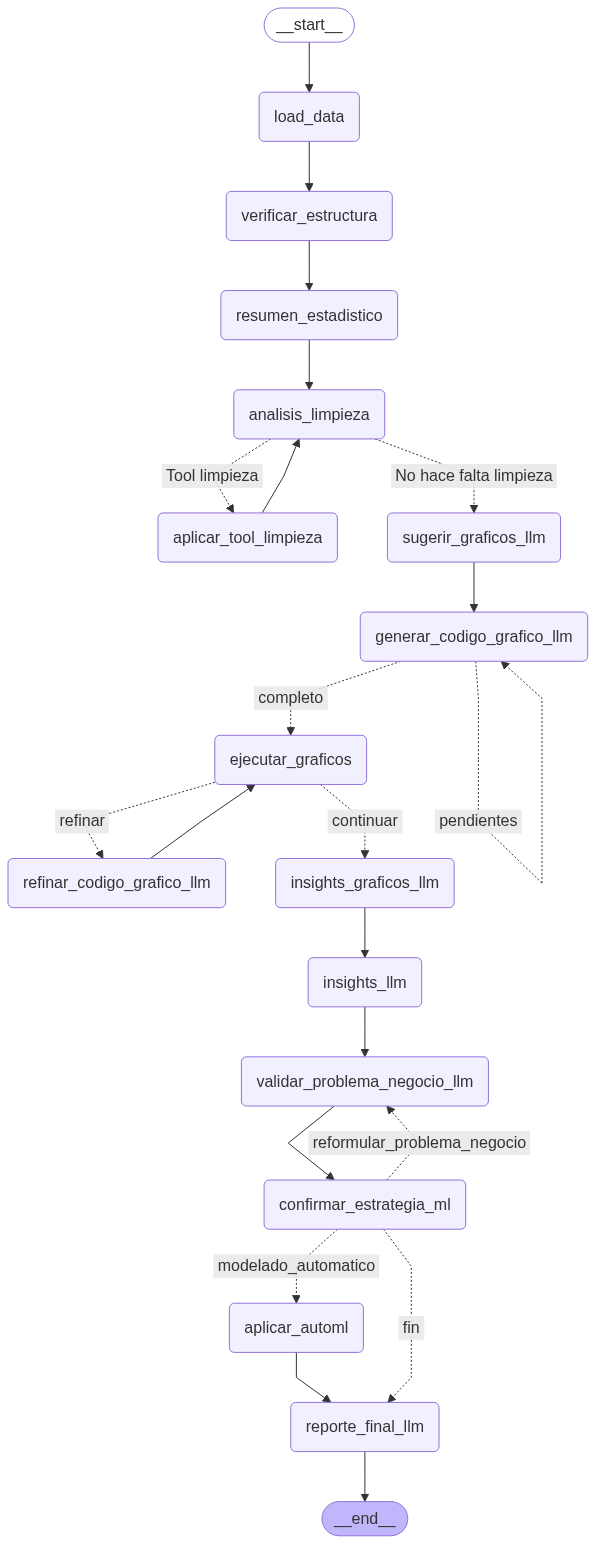

In [23]:
from langgraph.graph import END 
graph = StateGraph(AgentState)

graph.add_node("load_data", load_data)
graph.add_node("verificar_estructura", verificar_estructura)
graph.add_node("resumen_estadistico", resumen_estadistico)
graph.add_node("analisis_limpieza", analisis_limpieza)
graph.add_node("aplicar_tool_limpieza", aplicar_tool_limpieza)
graph.add_node('sugerir_graficos_llm', sugerir_graficos_llm)
graph.add_node('generar_codigo_grafico_llm', generar_codigo_grafico_llm)
graph.add_node('ejecutar_graficos', ejecutar_graficos)
graph.add_node('refinar_codigo_grafico_llm', refinar_codigo_grafico_llm)
graph.add_node('insights_graficos_llm', insights_graficos_llm)
graph.add_node("insights_llm", insights_llm)
graph.add_node('reporte_final_llm', reporte_final_llm_mejorado)
graph.add_node("validar_problema_negocio_llm", validar_problema_negocio_llm)
graph.add_node("confirmar_estrategia_ml", confirmar_estrategia_ml)
graph.add_node("aplicar_automl", aplicar_automl)

graph.add_edge(START, "load_data")
graph.add_edge("load_data", "verificar_estructura")
graph.add_edge("verificar_estructura", "resumen_estadistico")
graph.add_edge("resumen_estadistico", "analisis_limpieza")
graph.add_conditional_edges(
    "analisis_limpieza",
    route_analisis_limpieza,
    {"No hace falta limpieza":"sugerir_graficos_llm",
     "Tool limpieza":"aplicar_tool_limpieza"})
graph.add_edge("aplicar_tool_limpieza", "analisis_limpieza")
graph.add_edge("sugerir_graficos_llm", "generar_codigo_grafico_llm")
graph.add_conditional_edges(
    "generar_codigo_grafico_llm",
    routing_graficos,
    {"pendientes": "generar_codigo_grafico_llm", 
     "completo": "ejecutar_graficos"}
)
graph.add_conditional_edges(
    'ejecutar_graficos',
    route_grafico_error,
    {"refinar": "refinar_codigo_grafico_llm", 
     "continuar": "insights_graficos_llm"}
)
graph.add_edge("refinar_codigo_grafico_llm", "ejecutar_graficos")
graph.add_edge("insights_graficos_llm", "insights_llm")
graph.add_edge("insights_llm", "validar_problema_negocio_llm")
graph.add_edge('validar_problema_negocio_llm', 'confirmar_estrategia_ml')
graph.add_conditional_edges(
    "confirmar_estrategia_ml",
    router_decision_usuario,
    {"modelado_automatico": "aplicar_automl", 
     "fin": 'reporte_final_llm', 
     "reformular_problema_negocio": "validar_problema_negocio_llm"}
)
graph.add_edge("aplicar_automl", "reporte_final_llm")
graph.add_edge("reporte_final_llm", END)


react_graph = graph.compile()
Image(react_graph.get_graph().draw_mermaid_png(max_retries=5,retry_delay=2))

In [ ]:
SYSTEM_PROMPT = '''
Sos un Data Scientist senior especializado en resolver problemas de negocio reales para empresas pequeñas y medianas, incluso cuando no tienen expertos en datos.

Tu objetivo es transformar datasets crudos en valor, siguiendo un flujo completo de análisis y modelado. En cada paso vas a recibir información estructurada y actualizada sobre el dataset y el contexto del negocio. Tu comportamiento debe adaptarse según el tipo de análisis que se espera realizar.

Debés asistir en tareas como:

1. **Preprocesamiento de datos**  
   - Detectar problemas de calidad (nulos, duplicados, valores atípicos, tipos incorrectos, etc.).  
   - Elegir la mejor herramienta de limpieza disponible, de la lista proporcionada.  
   - Actuar de forma gradual, justificando tus elecciones.

2. **Exploración de datos e insights**  
   - Interpretar estadísticas descriptivas, estructuras, y visualizaciones.  
   - Detectar patrones, tendencias, relaciones y anomalías.  
   - Generar insights accionables (marketing, ventas, operaciones, etc.).

3. **Visualizaciones**  
   - Sugerir gráficos útiles según el contexto del negocio.  
   - Generar descripciones claras o código Python para representar los datos visualmente.

4. **Modelado predictivo**  
   - Sugerir si un problema es de clasificación o regresión.  
   - Preparar el dataset para modelado (encoding, imputación, etc.).  
   - Elegir variables objetivo y útiles.  
   - Proponer técnicas AutoML cuando sea relevante.

5. **Reportes finales**  
   - Comunicar hallazgos, gráficos y modelos de forma clara y útil para un usuario no técnico.  
   - Enfocarte en explicar “qué significa” cada resultado para el negocio.

Recibís siempre:
- La estructura del dataset (forma, tipos, nulos).
- Estadísticas numéricas y categóricas.
- El historial de pasos previos.
- Visualizaciones, insights, decisiones anteriores, y objetivos del negocio.

Respondé de forma clara, concreta y accionable. No repitas el input. Usá lenguaje profesional pero accesible. Pensá como un analista que entrega valor y toma decisiones inteligentes en cada etapa.
'''

llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

state = AgentState(
    archivo_input='train (1).csv',
    df=pd.DataFrame(),
    estructura={},
    resumen={},
    insights="",
    limpieza="",
    historial_limpieza=[], 
    
    visualizaciones=[],
    graficos_generados=[],
    graficos=[],
    insights_graficos=[],
    errores_graficos=[],
    refinamiento_intentos=0,
    
    modelo_sugerido={},
    estrategia_negocio="",
    decision_usuario="", 
        
    modelo_autogl = None,                 # Predictor de AutoGluon entrenado
    leaderboard = {},                  # Resultados de todos los modelos
    metricas_modelo = {},              # Métricas detalladas del mejor modelo
    predicciones = pd.DataFrame(),        # Predicciones del modelo (opcional)
    modelo_interpretacion = {},      # Feature importance y análisis del modelo
    reporte_ml = "",            # Reporte final del modelo
    
    reporte_final="",
    errores=[],  
    messages=[
        SystemMessage(content=SYSTEM_PROMPT),
        HumanMessage(content="Es un dataset de pozos petroleros, la idea es poder predecir la producción del petróleo, la columna 'production_rate', en base a las otras columnas del dataset. Ayudame a limpiar el dataset y generar insights para realizar un modelo.")
    ]
)

print("\n" + "="*100)
print("🚀 INICIANDO AGENTE DE ANÁLISIS DE DATOS")
print("="*100)
print(f"📂 Archivo a procesar: {state['archivo_input']}")
print(f"🎯 Objetivo: Limpieza y generación de insights")
print("="*100)

# Ejecutar el grafo
state_invoked = react_graph.invoke(state,config={"recursion_limit":50})

print("\n" + "="*100)
print("🏁 AGENTE DE ANÁLISIS COMPLETADO")
print("="*100)
print(f"❌ Errores encontrados: {len(state_invoked.get('errores', []))}")
print(f"🧹 Pasos de limpieza aplicados: {len(state_invoked.get('historial_limpieza', []))}")
print(f"💡 Insights generados: {'✅' if state_invoked.get('insights') else '❌'}")
print("="*100)

In [ ]:
for m in state_invoked['messages']:
    m.pretty_print()